In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

import random
#from deap import base, creator, tools
            
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

2024-11-21 13:30:03.815640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 13:30:04.163579: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 13:30:04.915899: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fernando/anaconda3/envs/tf/lib/
2024-11-21 13:30:04.916992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plug

# Pré tratamento da base de dados
- Normalização dos atributos utilizando scaler entre 0 e 1
- Conversão dos angulos azimutais para sua versão de cos e sen
- Normalização da irrad e potencia

In [2]:
df = pd.read_csv( '/mnt/c/Users/ferna/OneDrive/Documentos/mestrado/df.csv', sep=',')
df.rename(columns={"Unnamed: 0":"Date_Time"}, inplace = True)
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df.drop_duplicates(inplace = True)
df.drop(30625, inplace = True)
df.set_index('Date_Time',inplace = True)


df1 = pd.read_csv( '/mnt/c/Users/ferna/OneDrive/Documentos/mestrado/base_full.csv', sep=',')
#df.rename(columns={"Unnamed: 0":"Date_Time"}, inplace = True)
df1 = df1.drop(columns=['Unnamed: 0'], axis=1)
df1['Date_Time'] = pd.to_datetime(df1['Date_Time'])
df1 = df1.drop_duplicates()
df1.drop(21688, inplace = True)
df1.drop(7017, inplace = True)
df1.drop(891, inplace = True)
df1.drop(0, inplace = True)
df1.set_index('Date_Time',inplace = True)


df = df.join(df1[["Temp","Irrad"]])


#Potencia céu claro
U0, U1 = 25, 6.84
Pstc, Gstc, Tstc, y = 156000, 1000, 25, 0.0045
df['Temperatura celula'] = df['Temperatura ambiente °C'] + (df['ghi']/(U0 + U1*df['Velocidade média do vento m/s']))
df['Pot_cs'] = Pstc*(df['ghi']/Gstc)*(1-y*(df['Temperatura celula']-Tstc))/1000

#calculo do k
df['k'] = df['Pot_BT']/df['Pot_cs']
df['k'] = df['k'].replace([np.nan, np.inf, -np.inf], 0)
df['k'] = df['k'].clip(upper=1)

#calculo da persistencia
df_p1 = df[['Pot_cs']].loc[df.index[0]+timedelta(hours = 1):]
df_p2 = df[['Pot_cs']].loc[df.index[0]+timedelta(hours = 2):]
df_p3 = df[['Pot_cs']].loc[df.index[0]+timedelta(hours = 3):]

k = df['k'].to_list()

df_p1['P1'] = df_p1['Pot_cs']*k[:-1]
df_p2['P2'] = df_p2['Pot_cs']*k[:-2]
df_p3['P3'] = df_p3['Pot_cs']*k[:-3]

#conversão em dataframe
df = df.join([df_p1['P1'], df_p2['P2'], df_p3['P3']])

#Normalização dos atributos
df.reset_index(inplace = True)

#Normalização por scaler
data = df[['Temperatura ambiente °C',
           'Velocidade média do vento m/s',
           'Temp']]
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(data)
df_transformado=pd.DataFrame(scaler.transform(data),columns=data.columns)
df.drop(df_transformado.columns, axis=1, inplace = True)
df = df.join(df_transformado)

#Normalização 
df['Umidade Relativa %'] /= 100
df['cos_zenith']  = np.cos(np.deg2rad(df['zenith']))
df['sin_azimuth'] = np.sin(np.deg2rad(df['azimuth']))
df['Irradiação Global horária(Inclinada 27°) kWh/m2'] /= df['Extra Radiation']
df['Irrad'] /= df['Extra Radiation']

#Normalização da potencia
df['Pot_BT'] /= 156
df['P1'] /= 156
df['P2'] /= 156
df['P3'] /= 156

df['Pot_BT'] = df['Pot_BT'].replace([np.nan, np.inf], -1)
df['Irrad'] = df['Irrad'].replace([np.nan, np.inf], -1)
df['Temp'] = df['Temp'].replace([np.nan, np.inf], -1)

#df.set_index("Date_Time", inplace = True)

df.head(24)

,Date_Time,Irradiação Global horária(horizontal) kWh/m2,Irradiação Difusa horária kWh/m2,Irradiação Global horária(Inclinada 27°) kWh/m2,Umidade Relativa %,Pressão Baromêtrica mm Hg,Pluviômetro mm,ghi,dni,dhi,...,Pot_cs,k,P1,P2,P3,Temperatura ambiente °C,Velocidade média do vento m/s,Temp,cos_zenith,sin_azimuth
0,2018-01-01 00:00:00,0.0,0.0,0.000000,0.8600,761.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,NaN,NaN,NaN,0.518260,0.078110,-1.000000,-0.686643,-0.057149
1,2018-01-01 01:00:00,0.0,0.0,0.000000,0.8750,761.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,NaN,0.510471,0.051109,0.319247,-0.667840,0.265718
2,2018-01-01 02:00:00,0.0,0.0,0.000000,0.8920,761.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,0.498933,0.049662,0.310259,-0.592917,0.526091
3,2018-01-01 03:00:00,0.0,0.0,0.000000,0.8940,760.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.496048,0.059306,0.303593,-0.466976,0.701900
4,2018-01-01 04:00:00,0.0,0.0,0.000000,0.9010,761.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.489125,0.018804,0.300839,-0.298591,0.812505
5,2018-01-01 05:00:00,8.0,7.0,0.004951,0.8980,761.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.496048,0.040501,0.300537,-0.099227,0.881760
6,2018-01-01 06:00:00,95.0,61.0,0.045262,0.8580,761.0,0.0,59.794150,292.831657,24.732522,...,9.360205,0.536714,0.000000,0.000000,0.000000,0.534126,0.127772,0.317651,0.117539,0.926048
7,2018-01-01 07:00:00,255.0,147.0,0.140737,0.7730,762.0,0.0,295.985377,696.277072,60.850105,...,44.135015,0.502924,0.151845,0.000000,0.000000,0.597300,0.202025,0.365854,0.336943,0.955066
8,2018-01-01 08:00:00,342.0,252.0,0.206509,0.7660,762.0,0.0,541.674815,846.406473,80.873264,...,78.060327,0.428286,0.251657,0.268564,0.000000,0.579127,0.315333,0.488644,0.544043,0.974384
9,2018-01-01 09:00:00,431.0,327.0,0.272281,0.7190,762.0,0.0,759.814215,917.063581,95.015871,...,105.258333,0.411169,0.288979,0.339339,0.362138,0.613166,0.367888,0.504898,0.724728,0.987210


# Avaliação dos modelos

In [2]:
def avaliacao_ae(m, xs, ys, ysi):
    y = m.predict(xs)
    #Montagem do DataFrame
    lista_df = list()
    for h in range (0,3):
        lista = list()
        
        for i, j in zip(ysi, y):
            lista.append(
                {
                    "Date_Time":i[h],
                    f"Previsao_{h+1}":j[h][0]
                })
            
        x = pd.DataFrame(lista)
        x.set_index("Date_Time", inplace = True)
        lista_df.append(x)
       
    lista_ = list()
    for h in range (0,3):
        lista = list()
        
        for i, j in zip(ysi, ys):
            lista.append(
                {
                    "Date_Time":i[h],
                    "Observado":j[h][0]
                })
            
        x = pd.DataFrame(lista)
        x.set_index("Date_Time", inplace = True)
        lista_.append(x)
        
    df_provisorio = pd.concat(lista_, axis = 1)
    df_provisorio = df_provisorio.mode(axis=1)
    
    lista_df.append(df_provisorio)
    
    df_final = pd.concat(lista_df, axis = 1)
    df_final.rename(columns = {0:'Observado'}, inplace = True)
    #df_final = df_final.join(persistencia)
 
    del (lista, lista_, df_provisorio, lista_df, x)

    # Analise
    for i in range (1,4):
        print('   --- Hora {0} Futuro ---   '.format(i))
        
        x = df_final[['Observado',f'Previsao_{i}']].loc[df_final['Observado']*156>=10]
        x.dropna(inplace = True)
        a = x[f'Previsao_{i}'] #previsto
        b = x['Observado'] #medido
        #c = x[f'P{i}']#persistencia
        
        #RMSE
        from sklearn.metrics import mean_squared_error
        rmse = mean_squared_error(a, b, squared=False)
        #Vies
        bias = np.mean(a-b)/np.mean(b)
        #Informações da curva 
        from sklearn.linear_model import LinearRegression
        r = LinearRegression().fit(np.array(b).reshape(-1, 1),np.array(a))
        #Skill Score
        #rmse_p = mean_squared_error(c, b, squared=False)
        #ss = 1 - (rmse/rmse_p)
        
        print(f"RMSE: {rmse} \nVies: {bias} \nCorrelação: {r.coef_[0]} \nIntercept: {r.intercept_} \n#Previsões: {len(a)}  \n")
        
        import seaborn as sns
        # Crie uma grade 2x2 para os subplots
        fig, axes = plt.subplots(figsize=(8, 6))
        
        # Plote os gráficos individuais em cada posição da grade
        ax = sns.regplot(x = b,y = a, marker='x', color='.3', line_kws=dict(color="r"), ax = axes)
        ax.set(xlabel = 'Valor medido pot', ylabel = 'Valor previsto pot')
        ax.set_title('{0} hora no futuro'.format(i))
                  
        # Ajuste o layout para evitar sobreposição
        plt.tight_layout()
        
        # Exiba o gráfico
        plt.show()

    return df_final

# Funções para criação dos DF

In [3]:
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.irradiance import get_extra_radiation
from pvlib.solarposition import get_solarposition

#Modelo de céu claro 
def clear_sky (dataframe, latitude, longitude):
    times = pd.date_range(dataframe.index[0], dataframe.index[-1], freq = 'H')
    loc = Location(latitude=latitude, longitude=longitude)  
    ineichen = loc.get_clearsky(times, model='ineichen', 
                            dni_extra=get_extra_radiation(times), 
                            solar_position=get_solarposition(times, latitude, longitude)[['apparent_zenith', 'zenith', 'apparent_elevation']])
    return ineichen

#Angulos zenitais e azimutais
def zenite_azimute (dataframe, latitude, longitude):
    times = pd.date_range(dataframe.index[0], dataframe.index[-1], freq = 'H')
    loc = Location(latitude=latitude, longitude=longitude)
    sp = loc.get_solarposition(times)
    return sp

#Montagem do dataframe
def create_df (p, lat, lon):
    df = pd.read_csv( f'/mnt/c/Users/ferna/OneDrive/Documentos/ONS-GIZ/dados/cce_potencia_medida/{p}', sep=',')
    df['Date_Time'] = pd.to_datetime(df['Date_Time'])
    df.set_index('Date_Time', inplace = True)
    df.rename(columns = {'Potencia_Medida (MW)' : 'Potencia'}, inplace = True)
  
    #posição solar
    sp = zenite_azimute(df,lat,lon)
    df = df.join(sp[['zenith', 'azimuth']])
    df['cos_zenith']  = np.cos(np.deg2rad(df['zenith']))
    df['sin_azimuth'] = np.sin(np.deg2rad(df['azimuth']))
    
    #céu claro
    cs = clear_sky(df,lat,lon)
    df = df.join(cs[['ghi']])
    df['Potencia_cs'] = df['ghi']*df['Potencia_Planta (MW)']/1000
    
    #Indice de claridade
    df['k'] = df['Potencia']/df['Potencia_cs']
    k = df['k'].to_list()

    #Persistencia H1
    df_p1 = df[['Potencia_cs']].loc[df.index[0]+timedelta(hours = 1):]
    df_p1['P1'] = df_p1['Potencia_cs']*k[:-1]
    df_p1 = df_p1.applymap(lambda x: min(x, df['Potencia_Planta (MW)'].values[0]))
    df_p1.fillna(0, inplace=True)
    df_p1 /= df['Potencia_Planta (MW)'].values[0]

    #Persistencia H2
    df_p2 = df[['Potencia_cs']].loc[df.index[0]+timedelta(hours = 2):]
    df_p2['P2'] = df_p2['Potencia_cs']*k[:-2]
    df_p2 = df_p2.applymap(lambda x: min(x, df['Potencia_Planta (MW)'].values[0]))
    df_p2.fillna(0, inplace=True)
    df_p2 /= df['Potencia_Planta (MW)'].values[0]

    #Persistencia H3
    df_p3 = df[['Potencia_cs']].loc[df.index[0]+timedelta(hours = 3):]
    df_p3['P3'] = df_p3['Potencia_cs']*k[:-3]
    df_p3 = df_p3.applymap(lambda x: min(x, df['Potencia_Planta (MW)'].values[0]))
    df_p3.fillna(0, inplace=True)
    df_p3 /= df['Potencia_Planta (MW)'].values[0]

    #Junção final do dataframe
    df = df.join([df_p1['P1'], df_p2['P2'], df_p3['P3']])
    df.index -= timedelta(hours=3)
    df = df.tz_localize(None)
    df['Potencia'] /= df['Potencia_Planta (MW)'] 
    df['Potencia_cs'] /= df['Potencia_Planta (MW)'] 
    return df

#Janela Deslizante
def janela_flutuante(df, n_past, n_future, input_tag):

    yt= []
    xt = []
    y_index = []
    
    index = df.loc[(df['Potencia'].isnull() == False)].index

    #Janela deslizante
    for i in index:
        #(np.isin(df['Pot_BT'].loc['2018-01-01 00:00:00':'2018-01-01 23:00:00'].value_counts().index,-1).sum())
        if (np.isin(df['Potencia'].loc[i:i + datetime.timedelta(hours=n_future-1)].value_counts().index, -1).sum() == 0):
            #evitar que tenha [0,0,0] adicionado agr
            if len(df['Potencia'].loc[i:i + datetime.timedelta(hours=n_future-1)].value_counts())>=3:
                if len(df[input_tag].loc[i - datetime.timedelta(hours = n_past) : i - datetime.timedelta(hours = 1)]) == n_past:
                    if df[input_tag].loc[i - datetime.timedelta(hours = n_past) : i - datetime.timedelta(hours = 1)].isnull().sum().sum() == 0:
                        y_index.append(df.loc[i:i + datetime.timedelta(hours=n_future-1)].index)
                        # Seleção da Potencia [dia que queres prever : até que dia no futuro] 
                        yt.append(df[['Potencia']].loc[i:i + datetime.timedelta(hours=n_future-1)])
                        #
                        xt.append(df[input_tag].loc[i - datetime.timedelta(hours = n_past) : i - datetime.timedelta(hours = 1)])
                        #kt.append(df[['Irradiação Global horária(Inclinada 27°) kWh/m2', 'Temperatura ambiente °C']].loc[i:i + datetime.timedelta(hours=n_future-1)])

    
    xt, yt = np.array(xt), np.array(yt)
    #y_index = np.array(y_index)
    #kt = np.array(kt)
        
    #return xt, yt, kt
    return xt, yt, y_index

# Analises

In [4]:
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
class Avaliacao:
    def __init__(self, dataframe_treino):
        self.df = dataframe_treino[['P1', 'P2', 'P3', 'zenith', 'Month', 'Potencia']]
        self.df = self.df.rename(columns={'Potencia': 'Observado'})
        
        #self.df = dataframe_treino[['P1', 'P2', 'P3', 'zenith', 'Month', 'Pot_BT',"Irrad/CeuClaro",
        #                            'Irradiação Global horária(Inclinada 27°) kWh/m2']]
        #self.df = self.df.rename(columns={'Irradiação Global horária(Inclinada 27°) kWh/m2': 'kt',
        #                                  'Pot_BT': 'Observado'})
        
        # Filtro: Observado ser maior que zero 
        self.df = self.df.loc[self.df['Observado'] > 0]

    def adicionar_modelo(self, modelo, xs, ys, ysi, nome_modelo: str):
        previsao = modelo.predict(xs)
        dfs_previsoes = self.criar_df(ysi, previsao, nome_modelo)

        df_final = pd.concat(dfs_previsoes, axis=1)
        self.df = self.df.join(df_final)
        self.df = self.df.loc[self.df['Observado'].notna()]

        # Adiciona condição de céu
        #self.df["Condição de céu"] = self.df["kt"].apply(self.sky_condition)

        # Adiciona classificação do mês
        self.df["Tipo de mes"] = self.df['Month'].apply(self.month_classification)

        # Adiciona classificação de zenite
        self.df["Faixa zenith"] = self.df['zenith'].apply(self.zenith_condition)

    @staticmethod
    def criar_df(ysi, valores, prefixo):
        try:
            return [pd.DataFrame(
                [{"Date_Time": i[h], f"{prefixo}_{h+1}": j[h][0]} for i, j in zip(ysi, valores)]
            ).set_index("Date_Time") for h in range(3)]
        except IndexError:  # Captura um possível erro de índice
            return [pd.DataFrame(
                [{"Date_Time": i[h], f"{prefixo}_{h+1}": j[h]} for i, j in zip(ysi, valores)]
            ).set_index("Date_Time") for h in range(3)]

    @staticmethod
    def sky_condition(kt):
        if kt > 0.65:
            return "Claro"
        elif kt < 0.4:
            return "Nublado"
        else:
            return "Parcialmente Nublado"

    @staticmethod
    def zenith_condition(zenith):
        if zenith >= 60:
            return "Maior que 60 graus"
        elif zenith <= 30:
            return "Menor que 30 graus"
        else:
            return "Entre 30 e 60 graus"

    @staticmethod
    def month_classification(month_num):
        if 4 <= month_num <= 9:
            return "Seco"  # Dry months: May to October
        else:
            return "Chuvoso"  # Rainy months: November to April

    def calcular_erros(self, data, i):
        list_info = []
        for m in [item for item in data.columns if item != 'Observado']:
            rmse_per = mean_squared_error(data[f'P{i}'], data['Observado'], squared=False)

            dict_info = {
                'RMSE': mean_squared_error(data[m], data['Observado'], squared=False),
                'pRMSE':mean_squared_error(data[m], data['Observado'], squared=False)/np.mean(data['Observado']),
                'MBE': np.mean(data[m] - data['Observado']),
                'pMBE': np.mean(data[m] - data['Observado']) / np.mean(data['Observado']),
                'MAE': mean_absolute_error(data[m], data['Observado']),
                'pMAE':mean_absolute_error(data[m], data['Observado'])/np.mean(data['Observado']),                
                'R2': data[[m, 'Observado']].corr().iloc[0, 1],
                'SS': 1 - (mean_squared_error(data[m], data['Observado'], squared=False) / rmse_per),
                'Razão std': data[m].std() / data['Observado'].std(),
                'Média Observado':np.mean(data['Observado']),
                'Previsões': len(data['Observado']),
                'Modelo': m,
                'Horizonte': i
            }

            list_info.append(dict_info)
        return list_info

    def erros(self, condicao='Normal'):
        itens_para_remover = ['zenith', 'Month', 'Observado', 'kt']
        modelos = [item for item in self.df.columns if item not in itens_para_remover]
        list_info = []

        for i in range(1, 4):
            modelos_com_i = [item for item in modelos if f'{i}' in item]
            modelos_com_i.append('Observado')

            if condicao == "Normal":
                data = self.df[modelos_com_i]
                data = data.dropna()
                list_info.extend(self.calcular_erros(data, i))
            else:
                for cond in self.df[condicao].unique():
                    data = self.df.loc[self.df[condicao] == cond, modelos_com_i]
                    data = data.dropna()
                    valores = self.calcular_erros(data, i)
                    for entry in valores:
                        entry['Condição'] = cond
                    list_info.extend(valores)
        self.df_info = pd.DataFrame(list_info)

# Transfer Learning

In [11]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

class TL:
    def __init__ (self, path, df, input_tag = ['Potencia']):
        self.path = fr"/mnt/c/Users/ferna/OneDrive/Documentos/mestrado/Modelos/Base de dados novas/{path}"
        
        self.n_past = int(path.split('_')[1][:-1])
        self.n_future = 3

        #base de dados
        self.df_treino = df.loc[(df['Year'] < 2022)]
        self.df_valida = pd.DataFrame()
        self.df_teste = pd.DataFrame()
        for i in range (1,13):
            try:
                t,v = train_test_split(df['Day'].loc[(df['Year'] == 2022) & (df['Month'] == i)].unique(), 
                                       test_size = 0.5, 
                                       shuffle = False)
                self.df_valida = self.df_valida._append(df.loc[(df['Year'] == 2022) & (df['Month'] == i) & df['Day'].isin(t)])
                self.df_teste = self.df_teste._append(df.loc[(df['Year'] == 2022) & (df['Month'] == i) & df['Day'].isin(v)])
            except:
                pass
        
        #treino
        self.xt, self.yt, self.yti = self.janela_flutuante(self.df_treino, self.n_past, self.n_future, input_tag)
        #validação
        self.xv, self.yv, self.yvi = self.janela_flutuante(self.df_valida, self.n_past, self.n_future, input_tag)
        #teste
        self.xs, self.ys, self.ysi = self.janela_flutuante(self.df_teste, self.n_past, self.n_future, input_tag)

        #Modelos
        self.model = load_model(self.path)
        self.model_wi = self.weight_ini() #utiliza o tl como incialização de pesos
        self.model_fe = self.feature_ext() #utiliza o tl como extração de features e retreina do zero o fim do modelo
        self.model_fe_wi = self.feature_ext(weight_inicialization = True) #utiliza o tl como extração de features e retreina o fim com incialização de pesos
        #Muda somente a ultima camada
        #self.model_fe_output = self.feature_ext_final_dense() #utiliza o tl como extração de features e retreina do zero o fim do modelo
        #self.model_fe_wi_output = self.feature_ext_final_dense(weight_inicialization = True) #utiliza o tl como extração de features e retreina o fim com incialização de pesos
        self.modelo_cru = self.EDLSTM(path)
        
    @staticmethod
    def optimizer (lr):
        return Adam(clipnorm = 1.0, learning_rate = lr)

    @staticmethod
    def copy_model (model_to_copy):
        m = tf.keras.models.clone_model(model_to_copy)
        m.set_weights(model_to_copy.get_weights())
        return m

    def EDLSTM(self, path, lr = 0.001):
        unit = int(path.split('_')[2][:-1])
        n_outputs = self.yt.shape[1]
        n_input = self.xt.shape[2]
        
        cru = Sequential()
        cru.add(LSTM(unit, activation='relu', input_shape=(self.n_past, n_input)))
        cru.add(RepeatVector(n_outputs))
        cru.add(LSTM(unit, activation='relu', return_sequences=True))
        cru.add(TimeDistributed(Dense(50, activation='relu')))
        cru.add(TimeDistributed(Dense(1)))
                
        cru.compile(loss='mse', optimizer=self.optimizer(lr))
        cru.build((None, self.n_past, 3))
        
        return cru

    
    def weight_ini (self, lr = 0.001):
        wi = self.copy_model(self.model)
        wi.compile(loss='mse', optimizer=self.optimizer(lr))
        return wi

    def feature_ext (self, lr = 0.001, weight_inicialization = False, modelo = "EDLSTM"):
        fe = self.copy_model(self.model)
        model_freeze = Sequential()
        
        if (modelo == 'EDLSTM') & (weight_inicialization == False):
            for layer in fe.layers[:3]:
                layer.trainable = False
                model_freeze.add(layer)

            model_freeze.add(TimeDistributed(Dense(50, activation='relu')))
            model_freeze.add(TimeDistributed(Dense(1)))
            model_freeze.compile(loss='mse', optimizer=self.optimizer(lr))
            model_freeze.build((None, self.n_past, 3))
            return model_freeze

        elif (modelo == 'EDLSTM') & (weight_inicialization == True):
            for layer in fe.layers[:3]:
                layer.trainable = False
                model_freeze.add(layer)
            for layer in fe.layers[3:]:
                model_freeze.add(layer)
            #model_freeze.add(m.layers[-1])
            model_freeze.compile(loss='mse', optimizer=self.optimizer(lr))
            model_freeze.build((None, self.n_past, 3))
            return model_freeze

    #Muda só o ultimo dense
    def feature_ext_final_dense (self, lr = 0.001, weight_inicialization = False, model = "EDLSTM"):
        m = self.copy_model(self.model)
        model_freeze = Sequential()
        
        if (model == 'EDLSTM') & (weight_inicialization == False):
            for layer in m.layers[:4]:
                layer.trainable = False
                model_freeze.add(layer)

            #model_freeze.add(TimeDistributed(Dense(50, activation='relu')))
            model_freeze.add(TimeDistributed(Dense(1), name ='out'))
            model_freeze.compile(loss='mse', optimizer=self.optimizer(lr))
            model_freeze.build((None, self.n_past, 3))
            return model_freeze

        elif (model == 'EDLSTM') & (weight_inicialization == True):
            for layer in m.layers[:4]:
                layer.trainable = False
                model_freeze.add(layer)

            model_freeze.add(m.layers[-1])
            model_freeze.compile(loss='mse', optimizer=self.optimizer(lr))
            model_freeze.build((None, self.n_past, 3))
            return model_freeze
    
    @staticmethod
    def janela_flutuante(df, n_past, n_future, input_tag):

        yt= []
        xt = []
        y_index = []

        index = df.loc[(df['Potencia'].isnull() == False)].index
           
        #Janela deslizante
        for i in index:
            #(np.isin(df['Pot_BT'].loc['2018-01-01 00:00:00':'2018-01-01 23:00:00'].value_counts().index,-1).sum())
            if (np.isin(df['Potencia'].loc[i:i + datetime.timedelta(hours=n_future-1)].value_counts().index, -1).sum() == 0):
                #evitar que tenha [0,0,0] adicionado agr
                if len(df['Potencia'].loc[i:i + datetime.timedelta(hours=n_future-1)].value_counts())>=3:
                    if len(df[input_tag].loc[i - datetime.timedelta(hours = n_past) : i - datetime.timedelta(hours = 1)]) == n_past:
                        if df[input_tag].loc[i - datetime.timedelta(hours = n_past) : i - datetime.timedelta(hours = 1)].isnull().sum().sum() == 0:
                            y_index.append(df.loc[i:i + datetime.timedelta(hours=n_future-1)].index)
                            yt.append(df[['Potencia']].loc[i:i + datetime.timedelta(hours=n_future-1)])
                            xt.append(df[input_tag].loc[i - datetime.timedelta(hours = n_past) : i - datetime.timedelta(hours = 1)])

        xt, yt = np.array(xt), np.array(yt)
        return xt, yt, y_index
    
    def fine_tuning (self, model, lr = 1*10**(-6), months = 12, patience = 50):
        for layer in model.layers:
            layer.trainable = True
            
        model.compile(loss = 'mse', optimizer = self.optimizer(lr))
        self.training(model, months=months, patience = patience)  

    def training (self, model, patience = 50, months=12):
        early_stopping = EarlyStopping(monitor='val_loss',         
                                           patience=patience,               
                                           restore_best_weights=True) 
        if months == 12:
            history = model.fit(self.xt, 
                                self.yt, 
                                epochs=10000, 
                                batch_size=64, 
                                verbose=1,
                                callbacks = [early_stopping],
                                validation_data=(self.xv, self.yv))
        else:
            t = (self.xt.shape[0]//12)*(12-months)
            v = (self.xv.shape[0]//12)*(months)
            history = model.fit(self.xt[t:], 
                    self.yt[t:], 
                    epochs=10000, 
                    batch_size=16, 
                    verbose=1,
                    callbacks = [early_stopping],
                    validation_data=(self.xv[:v], self.yv[:v]))
            
        rmse = np.sqrt(min(history.history['val_loss']))
        
        plt.plot(history.history['loss'], label='Training loss')
        plt.plot(history.history['val_loss'], label='Validation loss')
        plt.legend()
        plt.show()

    def save (self, model, tf_option, local):
        type = self.path.split('/')[-1][:-3]
        it = type.split('_')[-1]
        model_type = type.split('_')[0]
        #model.save(fr"/mnt/c/Users/ferna/OneDrive/Documentos/mestrado/Modelos/Base de dados novas/Transfer Learning/{model_type}_{it}/repeticao/{type}_{tf_option}.h5")
        model.save(fr"/mnt/c/Users/ferna/OneDrive/Documentos/mestrado/Modelos/Base de dados novas/Transfer Learning/{model_type}_{it}/{local}/{type}_{tf_option}.h5")

## LSTM

In [5]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

class TL:
    def __init__ (self, path, df, input_tag = ['Potencia']):
        self.path = fr"/mnt/c/Users/ferna/OneDrive/Documentos/mestrado/Modelos/Base de dados novas/{path}"
        
        self.n_past = int(path.split('_')[1][:-1])
        self.n_future = 3

        #base de dados
        self.df_treino = df.loc[(df['Year'] < 2022)]
        self.df_valida = pd.DataFrame()
        self.df_teste = pd.DataFrame()
        for i in range (1,13):
            try:
                t,v = train_test_split(df['Day'].loc[(df['Year'] == 2022) & (df['Month'] == i)].unique(), 
                                       test_size = 0.5, 
                                       shuffle = False)
                self.df_valida = self.df_valida._append(df.loc[(df['Year'] == 2022) & (df['Month'] == i) & df['Day'].isin(t)])
                self.df_teste = self.df_teste._append(df.loc[(df['Year'] == 2022) & (df['Month'] == i) & df['Day'].isin(v)])
            except:
                pass
        
        #treino
        self.xt, self.yt, self.yti = self.janela_flutuante(self.df_treino, self.n_past, self.n_future, input_tag)
        #validação
        self.xv, self.yv, self.yvi = self.janela_flutuante(self.df_valida, self.n_past, self.n_future, input_tag)
        #teste
        self.xs, self.ys, self.ysi = self.janela_flutuante(self.df_teste, self.n_past, self.n_future, input_tag)

        #Modelos
        self.model = load_model(self.path)
        self.model_wi = self.weight_ini() #utiliza o tl como incialização de pesos
        self.model_fe = self.feature_ext() #utiliza o tl como extração de features e retreina do zero o fim do modelo
        self.model_fe_wi = self.feature_ext(weight_inicialization = True) #utiliza o tl como extração de features e retreina o fim com incialização de pesos
        #Muda somente a ultima camada
        #self.model_fe_output = self.feature_ext_final_dense() #utiliza o tl como extração de features e retreina do zero o fim do modelo
        #self.model_fe_wi_output = self.feature_ext_final_dense(weight_inicialization = True) #utiliza o tl como extração de features e retreina o fim com incialização de pesos
        self.modelo_cru = self.EDLSTM(path)
        
    @staticmethod
    def optimizer (lr):
        return Adam(clipnorm = 1.0, learning_rate = lr)

    @staticmethod
    def copy_model (model_to_copy):
        m = tf.keras.models.clone_model(model_to_copy)
        m.set_weights(model_to_copy.get_weights())
        return m

    def EDLSTM(self, path, lr = 0.001):
        unit = int(path.split('_')[2][:-1])
        n_outputs = self.yt.shape[1]
        n_input = self.xt.shape[2]
        
        cru = Sequential()
        cru.add(LSTM(unit, activation='relu', input_shape=(self.n_past, n_input)))
        cru.add(Dense(n_outputs))

        cru.compile(loss='mse', optimizer=self.optimizer(lr))
        cru.build((None, self.n_past, 3))
        
        return cru

    
    def weight_ini (self, lr = 0.001):
        wi = self.copy_model(self.model)
        wi.compile(loss='mse', optimizer=self.optimizer(lr))
        return wi

    def feature_ext (self, lr = 0.001, weight_inicialization = False, modelo = "EDLSTM"):
        fe = self.copy_model(self.model)
        model_freeze = Sequential()
        
        if (modelo == 'EDLSTM') & (weight_inicialization == False):
            fe.layers[0].trainable = False
            model_freeze.add(fe.layers[0])
            model_freeze.add(Dense(3))
 
            model_freeze.compile(loss='mse', optimizer=self.optimizer(lr))
            model_freeze.build((None, self.n_past, 3))
            return model_freeze

        elif (modelo == 'EDLSTM') & (weight_inicialization == True):
            fe.layers[0].trainable = False
            model_freeze.add(fe.layers[0])
            model_freeze.add(fe.layers[1])
 
            model_freeze.compile(loss='mse', optimizer=self.optimizer(lr))
            model_freeze.build((None, self.n_past, 3))
            return model_freeze
    
    @staticmethod
    def janela_flutuante(df, n_past, n_future, input_tag):

        yt= []
        xt = []
        y_index = []

        index = df.loc[(df['Potencia'].isnull() == False)].index
           
        #Janela deslizante
        for i in index:
            #(np.isin(df['Pot_BT'].loc['2018-01-01 00:00:00':'2018-01-01 23:00:00'].value_counts().index,-1).sum())
            if (np.isin(df['Potencia'].loc[i:i + datetime.timedelta(hours=n_future-1)].value_counts().index, -1).sum() == 0):
                #evitar que tenha [0,0,0] adicionado agr
                if len(df['Potencia'].loc[i:i + datetime.timedelta(hours=n_future-1)].value_counts())>=3:
                    if len(df[input_tag].loc[i - datetime.timedelta(hours = n_past) : i - datetime.timedelta(hours = 1)]) == n_past:
                        if df[input_tag].loc[i - datetime.timedelta(hours = n_past) : i - datetime.timedelta(hours = 1)].isnull().sum().sum() == 0:
                            y_index.append(df.loc[i:i + datetime.timedelta(hours=n_future-1)].index)
                            yt.append(df[['Potencia']].loc[i:i + datetime.timedelta(hours=n_future-1)])
                            xt.append(df[input_tag].loc[i - datetime.timedelta(hours = n_past) : i - datetime.timedelta(hours = 1)])

        xt, yt = np.array(xt), np.array(yt)
        return xt, yt, y_index
    
    def fine_tuning (self, model, lr = 1*10**(-6), months = 12, patience = 50):
        for layer in model.layers:
            layer.trainable = True
            
        model.compile(loss = 'mse', optimizer = self.optimizer(lr))
        self.training(model, months=months, patience = patience)  

    def training (self, model, patience = 50, months=12):
        early_stopping = EarlyStopping(monitor='val_loss',         
                                           patience=patience,               
                                           restore_best_weights=True) 
        if months == 12:
            history = model.fit(self.xt, 
                                self.yt, 
                                epochs=10000, 
                                batch_size=64, 
                                verbose=1,
                                callbacks = [early_stopping],
                                validation_data=(self.xv, self.yv))
        else:
            t = (self.xt.shape[0]//12)*(12-months)
            v = (self.xv.shape[0]//12)*(months)
            history = model.fit(self.xt[t:], 
                    self.yt[t:], 
                    epochs=10000, 
                    batch_size=16, 
                    verbose=1,
                    callbacks = [early_stopping],
                    validation_data=(self.xv[:v], self.yv[:v]))
            
        rmse = np.sqrt(min(history.history['val_loss']))
        
        plt.plot(history.history['loss'], label='Training loss')
        plt.plot(history.history['val_loss'], label='Validation loss')
        plt.legend()
        plt.show()

    def save (self, model, tf_option, local):
        type = self.path.split('/')[-1][:-3]
        it = type.split('_')[-1]
        model_type = type.split('_')[0]
        #model.save(fr"/mnt/c/Users/ferna/OneDrive/Documentos/mestrado/Modelos/Base de dados novas/Transfer Learning/{model_type}_{it}/repeticao/{type}_{tf_option}.h5")
        model.save(fr"/mnt/c/Users/ferna/OneDrive/Documentos/mestrado/Modelos/Base de dados novas/Transfer Learning/{model_type}_{it}/{local}/{type}_{tf_option}.h5")

# Playground

/tmp/ipykernel_702/1003709980.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_p1 = df_p1.applymap(lambda x: min(x, df['Potencia_Planta (MW)'].values[0]))
/tmp/ipykernel_702/1003709980.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_p2 = df_p2.applymap(lambda x: min(x, df['Potencia_Planta (MW)'].values[0]))
/tmp/ipykernel_702/1003709980.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_p3 = df_p3.applymap(lambda x: min(x, df['Potencia_Planta (MW)'].values[0]))
/home/fernando/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fernando/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

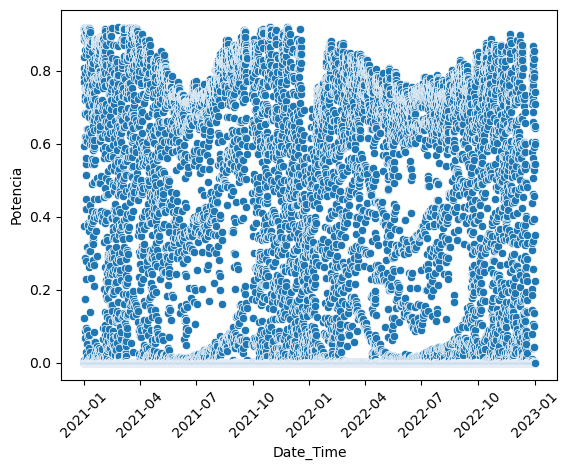

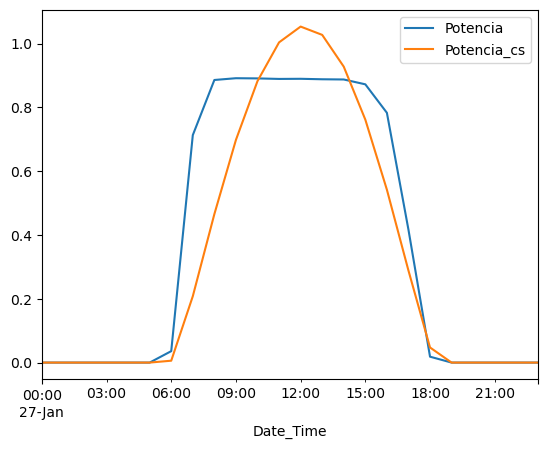

CCE18.csv 2020-12-31 21:00:00 2022-12-31 20:00:00


In [33]:
pontos = ['NEKT_tl.csv','CCE03.csv', 'CCE13.csv', 'CCE14.csv', 'CCE18.csv', 'CCE21.csv', 'CCE22.csv', 'CCE25.csv', 'CCE27.csv', 'CCE29.csv', 'CCE30.csv', 'CCE31.csv']
latitude =  [-23.045, -15.54 , -9.07  , -9.071 , -15.129, -27.578, -27.058, -9.541,  -27.688, -27.356, -22.816, -6.004]
longitude = [-46.674, -43.628, -38.147, -38.146, -44.139, -48.508, -52.785, -48.538, -53.307, -53.189, -47.059, -40.275]
#uf_list =     ['SP', 'PE', 'PE', 'MG', 'SC', 'SC', 'TO', 'RS', 'RS', 'SP', 'CE']
#regiao_list = ['SE', 'NE', 'NE', 'SE', 'S', 'S', 'N', 'S', 'S', 'SE', 'NE']
# 0, 2, 4, 5
i = 4

df = create_df(pontos[i], latitude[i], longitude[i])
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day


ax = sns.scatterplot(data = df['Potencia'])
plt.xticks(rotation=45)
plt.show()

b = df[['Potencia']].resample('D').mean()
c = b.loc[b['Potencia']==max(b['Potencia'])].index
c = str(c[0])[:10]

ini = f'{c} 00:00:00'
f = f'{c} 23:00:00'
df[['Potencia', 'Potencia_cs']].loc[ini:f].plot()
plt.show()

print(pontos[i],df.index[0], df.index[-1])

#path = "EDLSTM_72t_300u_3f_P.h5"
#path = "LSTM_24t_300u_3f_PAZ.h5"
path = "EDLSTM_24t_300u_3f_PAZ.h5"

input_tag = ['Potencia','cos_zenith','sin_azimuth']
#input_tag = ['Potencia','sin_azimuth','cos_zenith']
#input_tag = ['Potencia']

cce = pontos[i][:-4]

tl = TL(path, df, input_tag=input_tag)

Epoch 1/10000
 1/66 [..............................] - ETA: 3:05 - loss: 0.0111

2024-11-20 11:21:14.452373: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


66/66 [==============================] - 9s 96ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 2/10000
66/66 [==============================] - 6s 94ms/step - loss: 0.0095 - val_loss: 0.0104
Epoch 3/10000
66/66 [==============================] - 6s 93ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 4/10000
66/66 [==============================] - 6s 94ms/step - loss: 0.0090 - val_loss: 0.0104
Epoch 5/10000
66/66 [==============================] - 6s 90ms/step - loss: 0.0089 - val_loss: 0.0100
Epoch 6/10000
66/66 [==============================] - 6s 93ms/step - loss: 0.0090 - val_loss: 0.0096
Epoch 7/10000
66/66 [==============================] - 6s 91ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 8/10000
66/66 [==============================] - 6s 93ms/step - loss: 0.0087 - val_loss: 0.0106
Epoch 9/10000
66/66 [==============================] - 6s 91ms/step - loss: 0.0087 - val_loss: 0.0098
Epoch 10/10000
66/66 [==============================] - 6s 90ms/step - loss: 0.0087 - val_loss: 

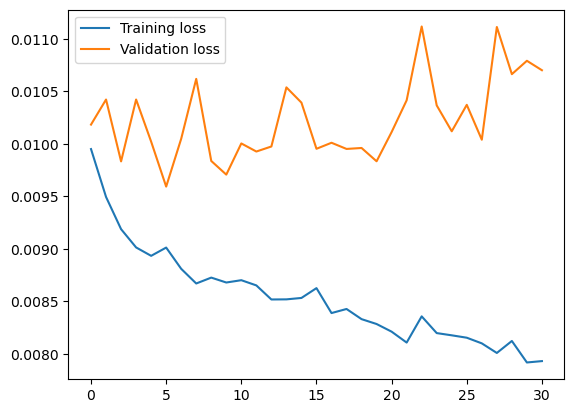

Epoch 1/10000
66/66 [==============================] - 4s 47ms/step - loss: 0.0340 - val_loss: 0.0144
Epoch 2/10000
66/66 [==============================] - 3s 42ms/step - loss: 0.0112 - val_loss: 0.0128
Epoch 3/10000
66/66 [==============================] - 3s 43ms/step - loss: 0.0104 - val_loss: 0.0126
Epoch 4/10000
66/66 [==============================] - 3s 45ms/step - loss: 0.0101 - val_loss: 0.0125
Epoch 5/10000
66/66 [==============================] - 3s 46ms/step - loss: 0.0099 - val_loss: 0.0126
Epoch 6/10000
66/66 [==============================] - 3s 45ms/step - loss: 0.0099 - val_loss: 0.0125
Epoch 7/10000
66/66 [==============================] - 3s 47ms/step - loss: 0.0098 - val_loss: 0.0124
Epoch 8/10000
66/66 [==============================] - 3s 48ms/step - loss: 0.0097 - val_loss: 0.0122
Epoch 9/10000
66/66 [==============================] - 3s 47ms/step - loss: 0.0097 - val_loss: 0.0122
Epoch 10/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.009

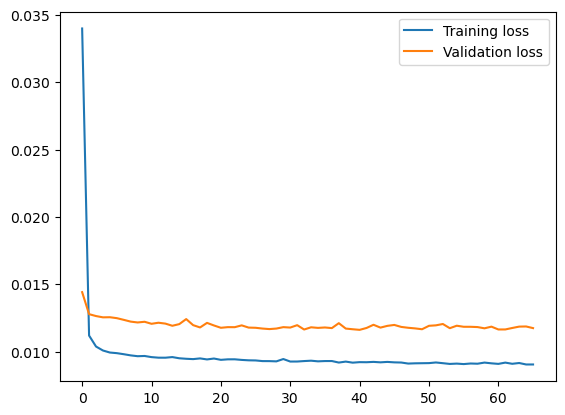

Epoch 1/10000
66/66 [==============================] - 4s 48ms/step - loss: 0.0111 - val_loss: 0.0130
Epoch 2/10000
66/66 [==============================] - 3s 46ms/step - loss: 0.0103 - val_loss: 0.0126
Epoch 3/10000
66/66 [==============================] - 3s 47ms/step - loss: 0.0100 - val_loss: 0.0125
Epoch 4/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.0099 - val_loss: 0.0124
Epoch 5/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.0097 - val_loss: 0.0125
Epoch 6/10000
66/66 [==============================] - 3s 45ms/step - loss: 0.0096 - val_loss: 0.0126
Epoch 7/10000
66/66 [==============================] - 3s 45ms/step - loss: 0.0096 - val_loss: 0.0123
Epoch 8/10000
66/66 [==============================] - 3s 45ms/step - loss: 0.0096 - val_loss: 0.0122
Epoch 9/10000
66/66 [==============================] - 3s 46ms/step - loss: 0.0095 - val_loss: 0.0122
Epoch 10/10000
66/66 [==============================] - 3s 43ms/step - loss: 0.009

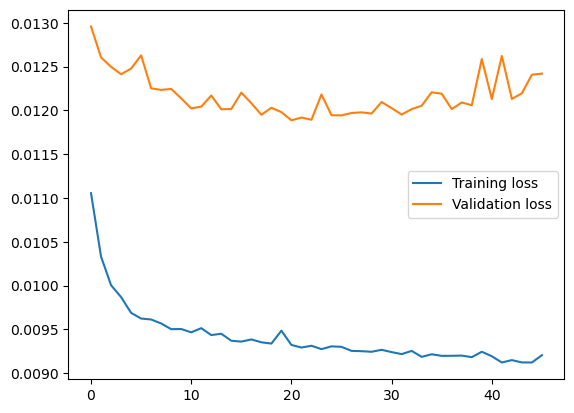

Epoch 1/10000
66/66 [==============================] - 7s 89ms/step - loss: 0.0312 - val_loss: 0.0191
Epoch 2/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.0145 - val_loss: 0.0140
Epoch 3/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.0122 - val_loss: 0.0134
Epoch 4/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.0119 - val_loss: 0.0131
Epoch 5/10000
66/66 [==============================] - 6s 84ms/step - loss: 0.0113 - val_loss: 0.0135
Epoch 6/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.0104 - val_loss: 0.0111
Epoch 7/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.0099 - val_loss: 0.0108
Epoch 8/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.0099 - val_loss: 0.0117
Epoch 9/10000
66/66 [==============================] - 6s 89ms/step - loss: 0.0099 - val_loss: 0.0105
Epoch 10/10000
66/66 [==============================] - 6s 91ms/step - loss: 0.009

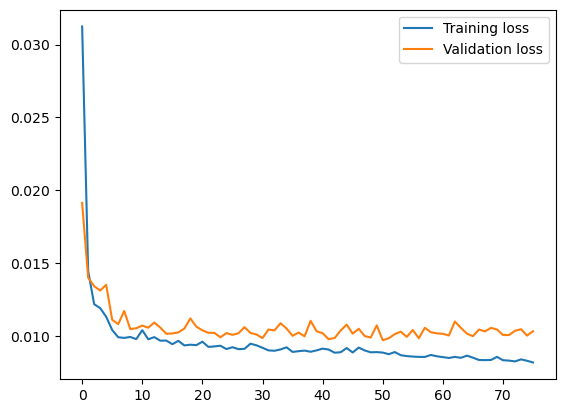

Epoch 1/10000
66/66 [==============================] - 7s 93ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 2/10000
66/66 [==============================] - 6s 91ms/step - loss: 0.0091 - val_loss: 0.0116
Epoch 3/10000
66/66 [==============================] - 6s 91ms/step - loss: 0.0091 - val_loss: 0.0116
Epoch 4/10000
66/66 [==============================] - 6s 89ms/step - loss: 0.0091 - val_loss: 0.0116
Epoch 5/10000
66/66 [==============================] - 6s 85ms/step - loss: 0.0091 - val_loss: 0.0116
Epoch 6/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.0091 - val_loss: 0.0115
Epoch 7/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.0091 - val_loss: 0.0115
Epoch 8/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.0091 - val_loss: 0.0115
Epoch 9/10000
66/66 [==============================] - 6s 89ms/step - loss: 0.0091 - val_loss: 0.0115
Epoch 10/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.009

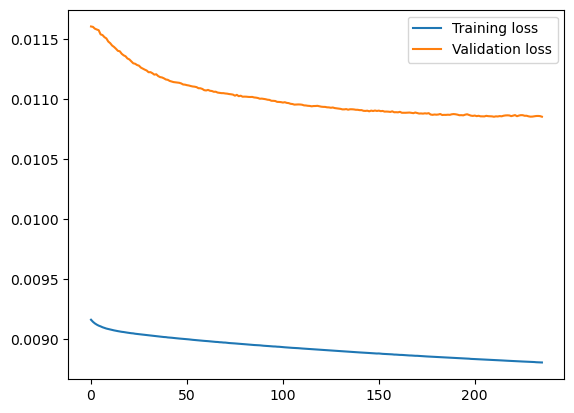

Epoch 1/10000
66/66 [==============================] - 7s 96ms/step - loss: 0.0093 - val_loss: 0.0119
Epoch 2/10000
66/66 [==============================] - 6s 93ms/step - loss: 0.0092 - val_loss: 0.0119
Epoch 3/10000
66/66 [==============================] - 6s 92ms/step - loss: 0.0092 - val_loss: 0.0119
Epoch 4/10000
66/66 [==============================] - 6s 89ms/step - loss: 0.0092 - val_loss: 0.0119
Epoch 5/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.0092 - val_loss: 0.0119
Epoch 6/10000
66/66 [==============================] - 5s 81ms/step - loss: 0.0092 - val_loss: 0.0118
Epoch 7/10000
66/66 [==============================] - 6s 85ms/step - loss: 0.0092 - val_loss: 0.0118
Epoch 8/10000
66/66 [==============================] - 6s 85ms/step - loss: 0.0092 - val_loss: 0.0118
Epoch 9/10000
66/66 [==============================] - 6s 83ms/step - loss: 0.0092 - val_loss: 0.0118
Epoch 10/10000
66/66 [==============================] - 6s 85ms/step - loss: 0.009

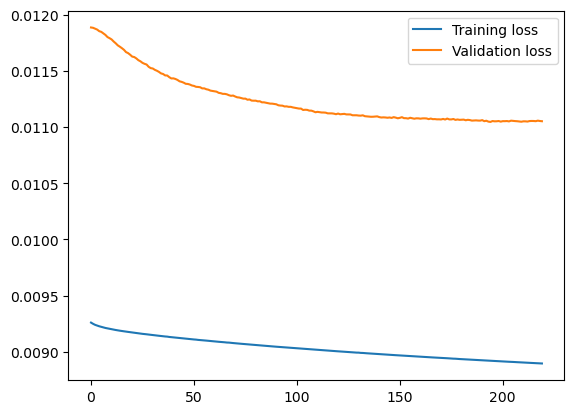

Epoch 1/10000
66/66 [==============================] - 7s 91ms/step - loss: 0.0098 - val_loss: 0.0104
Epoch 2/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.0094 - val_loss: 0.0104
Epoch 3/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.0093 - val_loss: 0.0104
Epoch 4/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.0090 - val_loss: 0.0108
Epoch 5/10000
66/66 [==============================] - 6s 84ms/step - loss: 0.0089 - val_loss: 0.0099
Epoch 6/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.0088 - val_loss: 0.0098
Epoch 7/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.0088 - val_loss: 0.0106
Epoch 8/10000
66/66 [==============================] - 6s 89ms/step - loss: 0.0088 - val_loss: 0.0117
Epoch 9/10000
66/66 [==============================] - 6s 85ms/step - loss: 0.0087 - val_loss: 0.0101
Epoch 10/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.008

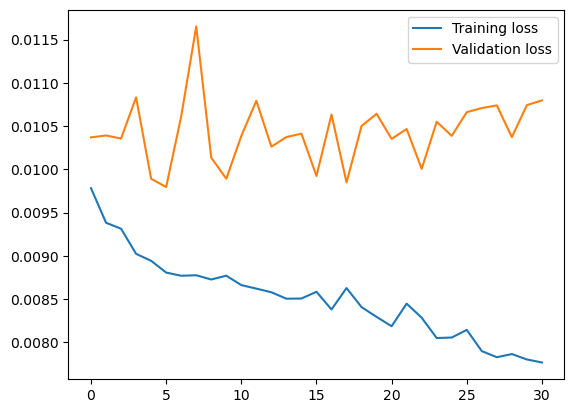

Epoch 1/10000
66/66 [==============================] - 4s 45ms/step - loss: 0.0279 - val_loss: 0.0139
Epoch 2/10000
66/66 [==============================] - 3s 40ms/step - loss: 0.0110 - val_loss: 0.0130
Epoch 3/10000
66/66 [==============================] - 3s 42ms/step - loss: 0.0103 - val_loss: 0.0129
Epoch 4/10000
66/66 [==============================] - 3s 42ms/step - loss: 0.0101 - val_loss: 0.0127
Epoch 5/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.0099 - val_loss: 0.0134
Epoch 6/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.0099 - val_loss: 0.0125
Epoch 7/10000
66/66 [==============================] - 3s 42ms/step - loss: 0.0097 - val_loss: 0.0127
Epoch 8/10000
66/66 [==============================] - 3s 45ms/step - loss: 0.0096 - val_loss: 0.0124
Epoch 9/10000
66/66 [==============================] - 3s 42ms/step - loss: 0.0096 - val_loss: 0.0124
Epoch 10/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.009

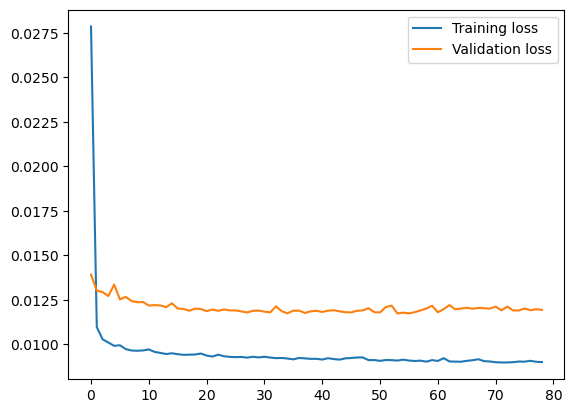

Epoch 1/10000
66/66 [==============================] - 4s 47ms/step - loss: 0.0109 - val_loss: 0.0127
Epoch 2/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.0102 - val_loss: 0.0127
Epoch 3/10000
66/66 [==============================] - 3s 42ms/step - loss: 0.0100 - val_loss: 0.0125
Epoch 4/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.0098 - val_loss: 0.0124
Epoch 5/10000
66/66 [==============================] - 3s 43ms/step - loss: 0.0097 - val_loss: 0.0124
Epoch 6/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.0096 - val_loss: 0.0122
Epoch 7/10000
66/66 [==============================] - 3s 43ms/step - loss: 0.0096 - val_loss: 0.0121
Epoch 8/10000
66/66 [==============================] - 3s 43ms/step - loss: 0.0096 - val_loss: 0.0122
Epoch 9/10000
66/66 [==============================] - 3s 41ms/step - loss: 0.0095 - val_loss: 0.0120
Epoch 10/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.009

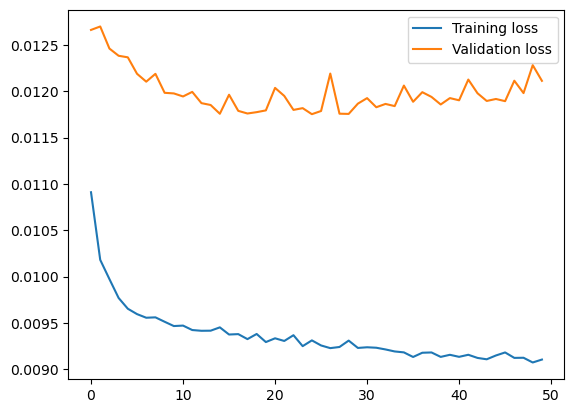

Epoch 1/10000
66/66 [==============================] - 7s 94ms/step - loss: 0.0356 - val_loss: 0.0203
Epoch 2/10000
66/66 [==============================] - 6s 93ms/step - loss: 0.0153 - val_loss: 0.0143
Epoch 3/10000
66/66 [==============================] - 6s 92ms/step - loss: 0.0128 - val_loss: 0.0139
Epoch 4/10000
66/66 [==============================] - 6s 92ms/step - loss: 0.0121 - val_loss: 0.0137
Epoch 5/10000
66/66 [==============================] - 6s 93ms/step - loss: 0.0114 - val_loss: 0.0124
Epoch 6/10000
66/66 [==============================] - 6s 93ms/step - loss: 0.0111 - val_loss: 0.0130
Epoch 7/10000
66/66 [==============================] - 6s 92ms/step - loss: 0.0104 - val_loss: 0.0112
Epoch 8/10000
66/66 [==============================] - 6s 90ms/step - loss: 0.0101 - val_loss: 0.0111
Epoch 9/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.0102 - val_loss: 0.0109
Epoch 10/10000
66/66 [==============================] - 6s 90ms/step - loss: 0.009

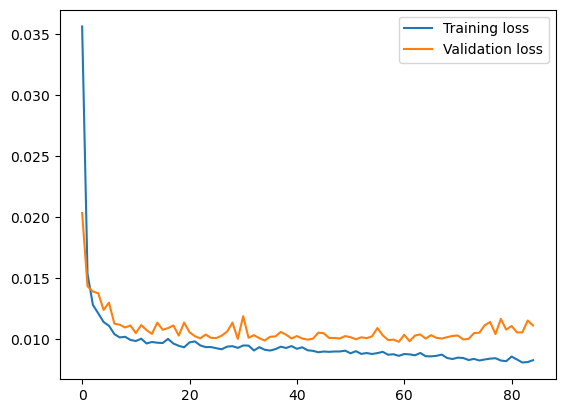

Epoch 1/10000
66/66 [==============================] - 7s 92ms/step - loss: 0.0090 - val_loss: 0.0117
Epoch 2/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.0090 - val_loss: 0.0117
Epoch 3/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.0090 - val_loss: 0.0117
Epoch 4/10000
66/66 [==============================] - 5s 82ms/step - loss: 0.0090 - val_loss: 0.0117
Epoch 5/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.0090 - val_loss: 0.0117
Epoch 6/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.0090 - val_loss: 0.0117
Epoch 7/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.0090 - val_loss: 0.0117
Epoch 8/10000
66/66 [==============================] - 6s 84ms/step - loss: 0.0090 - val_loss: 0.0116
Epoch 9/10000
66/66 [==============================] - 6s 84ms/step - loss: 0.0090 - val_loss: 0.0116
Epoch 10/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.008

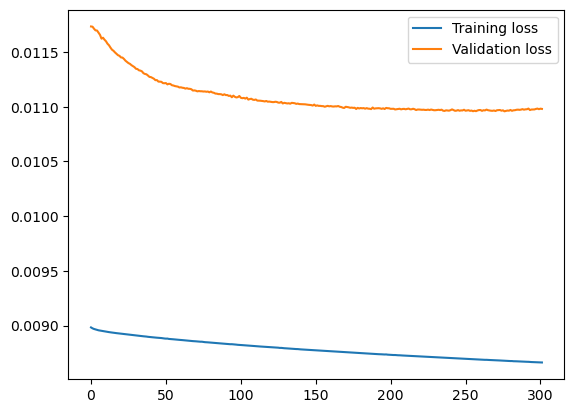

Epoch 1/10000
66/66 [==============================] - 7s 87ms/step - loss: 0.0092 - val_loss: 0.0117
Epoch 2/10000
66/66 [==============================] - 6s 84ms/step - loss: 0.0092 - val_loss: 0.0117
Epoch 3/10000
66/66 [==============================] - 6s 89ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 4/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 5/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 6/10000
66/66 [==============================] - 6s 89ms/step - loss: 0.0092 - val_loss: 0.0115
Epoch 7/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.0092 - val_loss: 0.0115
Epoch 8/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.0092 - val_loss: 0.0115
Epoch 9/10000
66/66 [==============================] - 6s 89ms/step - loss: 0.0092 - val_loss: 0.0115
Epoch 10/10000
66/66 [==============================] - 6s 85ms/step - loss: 0.009

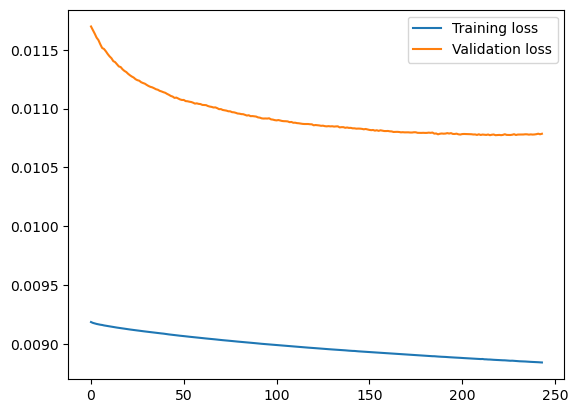

Epoch 1/10000
66/66 [==============================] - 7s 96ms/step - loss: 0.0098 - val_loss: 0.0103
Epoch 2/10000
66/66 [==============================] - 6s 91ms/step - loss: 0.0093 - val_loss: 0.0103
Epoch 3/10000
66/66 [==============================] - 6s 91ms/step - loss: 0.0092 - val_loss: 0.0102
Epoch 4/10000
66/66 [==============================] - 6s 91ms/step - loss: 0.0091 - val_loss: 0.0099
Epoch 5/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.0089 - val_loss: 0.0108
Epoch 6/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.0088 - val_loss: 0.0104
Epoch 7/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.0088 - val_loss: 0.0102
Epoch 8/10000
66/66 [==============================] - 6s 90ms/step - loss: 0.0088 - val_loss: 0.0103
Epoch 9/10000
66/66 [==============================] - 6s 92ms/step - loss: 0.0087 - val_loss: 0.0104
Epoch 10/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.008

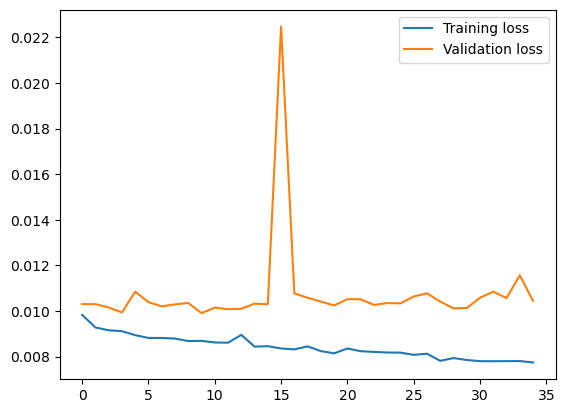

Epoch 1/10000
66/66 [==============================] - 4s 46ms/step - loss: 0.0261 - val_loss: 0.0131
Epoch 2/10000
66/66 [==============================] - 3s 43ms/step - loss: 0.0107 - val_loss: 0.0126
Epoch 3/10000
66/66 [==============================] - 3s 41ms/step - loss: 0.0102 - val_loss: 0.0124
Epoch 4/10000
66/66 [==============================] - 3s 45ms/step - loss: 0.0099 - val_loss: 0.0123
Epoch 5/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.0098 - val_loss: 0.0127
Epoch 6/10000
66/66 [==============================] - 3s 43ms/step - loss: 0.0098 - val_loss: 0.0125
Epoch 7/10000
66/66 [==============================] - 3s 46ms/step - loss: 0.0097 - val_loss: 0.0123
Epoch 8/10000
66/66 [==============================] - 3s 45ms/step - loss: 0.0096 - val_loss: 0.0124
Epoch 9/10000
66/66 [==============================] - 3s 46ms/step - loss: 0.0096 - val_loss: 0.0121
Epoch 10/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.009

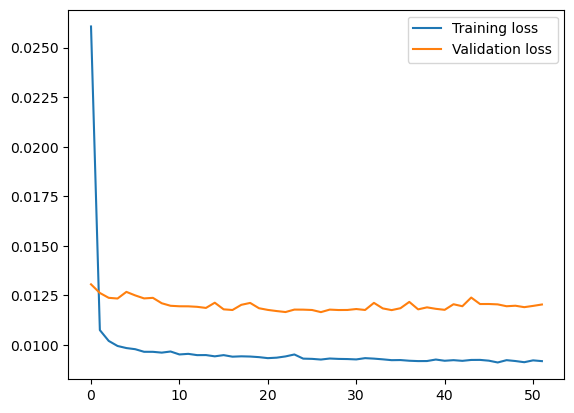

Epoch 1/10000
66/66 [==============================] - 4s 49ms/step - loss: 0.0110 - val_loss: 0.0128
Epoch 2/10000
66/66 [==============================] - 3s 47ms/step - loss: 0.0103 - val_loss: 0.0124
Epoch 3/10000
66/66 [==============================] - 3s 47ms/step - loss: 0.0100 - val_loss: 0.0124
Epoch 4/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.0098 - val_loss: 0.0124
Epoch 5/10000
66/66 [==============================] - 3s 41ms/step - loss: 0.0097 - val_loss: 0.0123
Epoch 6/10000
66/66 [==============================] - 3s 41ms/step - loss: 0.0097 - val_loss: 0.0123
Epoch 7/10000
66/66 [==============================] - 3s 42ms/step - loss: 0.0096 - val_loss: 0.0123
Epoch 8/10000
66/66 [==============================] - 3s 43ms/step - loss: 0.0095 - val_loss: 0.0122
Epoch 9/10000
66/66 [==============================] - 3s 43ms/step - loss: 0.0095 - val_loss: 0.0122
Epoch 10/10000
66/66 [==============================] - 3s 45ms/step - loss: 0.009

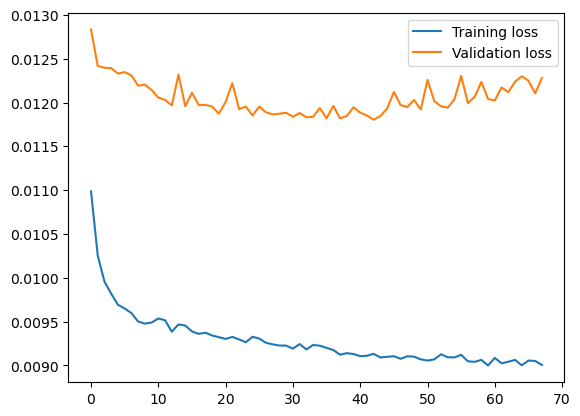

Epoch 1/10000
66/66 [==============================] - 7s 85ms/step - loss: 0.0364 - val_loss: 0.0193
Epoch 2/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.0150 - val_loss: 0.0257
Epoch 3/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 4/10000
66/66 [==============================] - 6s 93ms/step - loss: 0.0119 - val_loss: 0.0123
Epoch 5/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 6/10000
66/66 [==============================] - 6s 90ms/step - loss: 0.0106 - val_loss: 0.0117
Epoch 7/10000
66/66 [==============================] - 6s 92ms/step - loss: 0.0103 - val_loss: 0.0113
Epoch 8/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.0105 - val_loss: 0.0121
Epoch 9/10000
66/66 [==============================] - 6s 91ms/step - loss: 0.0101 - val_loss: 0.0110
Epoch 10/10000
66/66 [==============================] - 6s 92ms/step - loss: 0.009

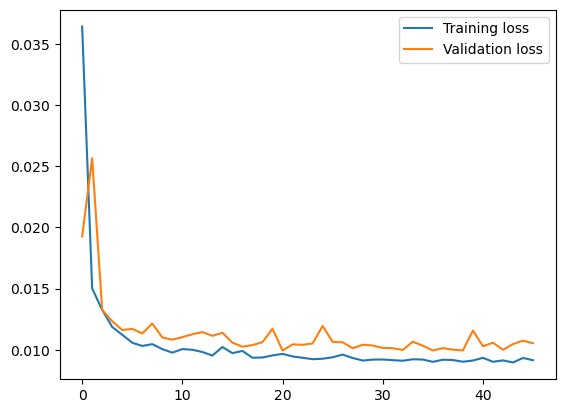

Epoch 1/10000
66/66 [==============================] - 7s 95ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 2/10000
66/66 [==============================] - 6s 98ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 3/10000
66/66 [==============================] - 6s 91ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 4/10000
66/66 [==============================] - 6s 93ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 5/10000
66/66 [==============================] - 6s 91ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 6/10000
66/66 [==============================] - 6s 92ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 7/10000
66/66 [==============================] - 6s 92ms/step - loss: 0.0092 - val_loss: 0.0115
Epoch 8/10000
66/66 [==============================] - 6s 90ms/step - loss: 0.0092 - val_loss: 0.0115
Epoch 9/10000
66/66 [==============================] - 6s 85ms/step - loss: 0.0092 - val_loss: 0.0115
Epoch 10/10000
66/66 [==============================] - 6s 89ms/step - loss: 0.009

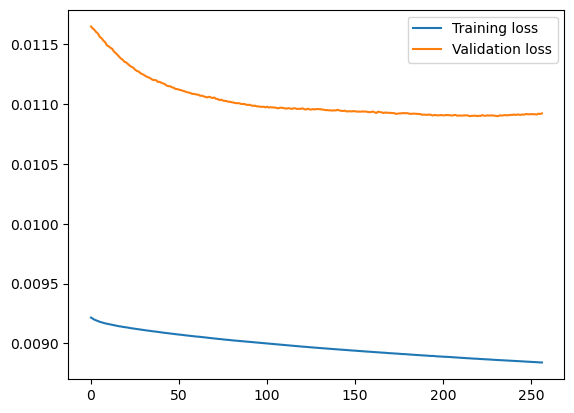

Epoch 1/10000
66/66 [==============================] - 7s 90ms/step - loss: 0.0091 - val_loss: 0.0118
Epoch 2/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.0090 - val_loss: 0.0118
Epoch 3/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.0090 - val_loss: 0.0118
Epoch 4/10000
66/66 [==============================] - 5s 83ms/step - loss: 0.0090 - val_loss: 0.0118
Epoch 5/10000
66/66 [==============================] - 6s 85ms/step - loss: 0.0090 - val_loss: 0.0118
Epoch 6/10000
66/66 [==============================] - 6s 91ms/step - loss: 0.0090 - val_loss: 0.0117
Epoch 7/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.0090 - val_loss: 0.0117
Epoch 8/10000
66/66 [==============================] - 6s 90ms/step - loss: 0.0090 - val_loss: 0.0117
Epoch 9/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.0090 - val_loss: 0.0117
Epoch 10/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.009

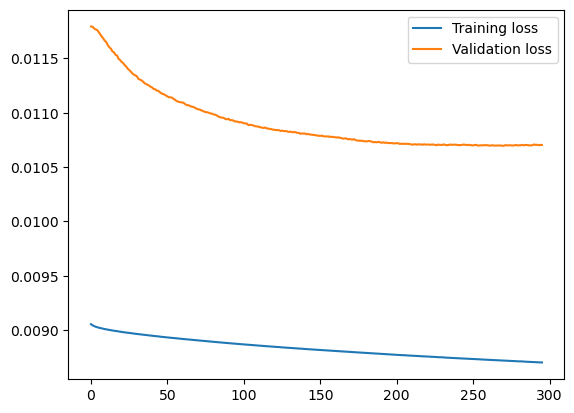

In [5]:
for count in range (0,20):
    tl = TL(path, df, input_tag=input_tag)

    models = [tl.model_wi,tl.model_fe,tl.model_fe_wi,
              tl.modelo_cru]
    meses = 12
    
    tl_option = [f'wi_{count}', f'fe_{count}', f'fewi_{count}',
                f'cru_{count}']
    
    for m, o in zip(models, tl_option):
        tl.training(m, months = meses, patience = 25)
        tl.save(m,o,cce)
    
    #Fine tuning
    ft = [tl.model_fe, tl.model_fe_wi]
    tl_option = [f'fe_ft_{count}', f'fewi_ft_{count}']
    
        
    for m, o in zip(ft, tl_option):
        tl.fine_tuning(m, months = meses, patience = 25)
        tl.save(m,o,cce)


Epoch 1/10000
24/24 [==============================] - 4s 134ms/step - loss: 0.0089 - val_loss: 0.0081
Epoch 2/10000
24/24 [==============================] - 2s 85ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 3/10000
24/24 [==============================] - 2s 85ms/step - loss: 0.0076 - val_loss: 0.0090
Epoch 4/10000
24/24 [==============================] - 2s 85ms/step - loss: 0.0073 - val_loss: 0.0079
Epoch 5/10000
24/24 [==============================] - 2s 83ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 6/10000
24/24 [==============================] - 2s 86ms/step - loss: 0.0075 - val_loss: 0.0078
Epoch 7/10000
24/24 [==============================] - 2s 87ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 8/10000
24/24 [==============================] - 2s 86ms/step - loss: 0.0071 - val_loss: 0.0092
Epoch 9/10000
24/24 [==============================] - 2s 89ms/step - loss: 0.0074 - val_loss: 0.0086
Epoch 10/10000
24/24 [==============================] - 2s 84ms/step - loss: 0.00

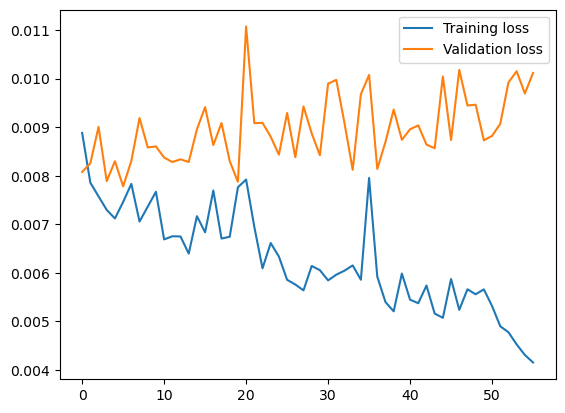

Epoch 1/10000
24/24 [==============================] - 2s 56ms/step - loss: 0.0502 - val_loss: 0.0137
Epoch 2/10000
24/24 [==============================] - 1s 48ms/step - loss: 0.0116 - val_loss: 0.0089
Epoch 3/10000
24/24 [==============================] - 1s 45ms/step - loss: 0.0094 - val_loss: 0.0081
Epoch 4/10000
24/24 [==============================] - 1s 46ms/step - loss: 0.0086 - val_loss: 0.0077
Epoch 5/10000
24/24 [==============================] - 1s 45ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 6/10000
24/24 [==============================] - 1s 47ms/step - loss: 0.0083 - val_loss: 0.0076
Epoch 7/10000
24/24 [==============================] - 1s 45ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 8/10000
24/24 [==============================] - 1s 48ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 9/10000
24/24 [==============================] - 1s 49ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 10/10000
24/24 [==============================] - 1s 48ms/step - loss: 0.007

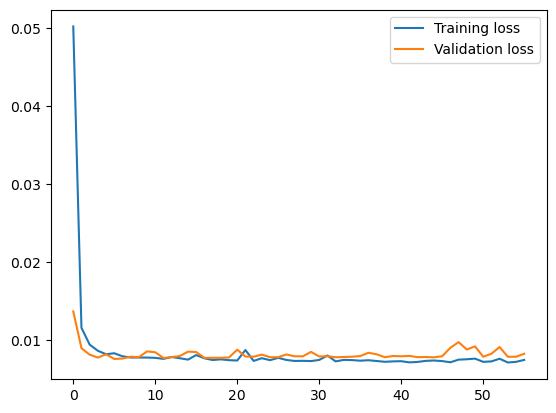

Epoch 1/10000
24/24 [==============================] - 2s 49ms/step - loss: 0.0093 - val_loss: 0.0082
Epoch 2/10000
24/24 [==============================] - 1s 42ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 3/10000
24/24 [==============================] - 1s 42ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 4/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 5/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 6/10000
24/24 [==============================] - 1s 42ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 7/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 8/10000
24/24 [==============================] - 1s 44ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 9/10000
24/24 [==============================] - 1s 42ms/step - loss: 0.0077 - val_loss: 0.0080
Epoch 10/10000
24/24 [==============================] - 1s 42ms/step - loss: 0.007

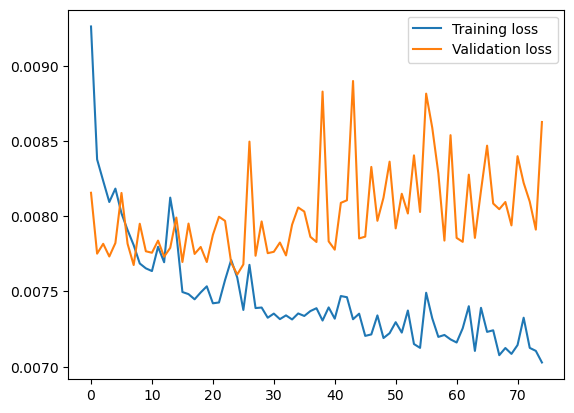

Epoch 1/10000
24/24 [==============================] - 3s 94ms/step - loss: 0.0705 - val_loss: 0.0368
Epoch 2/10000
24/24 [==============================] - 2s 91ms/step - loss: 0.0261 - val_loss: 0.0185
Epoch 3/10000
24/24 [==============================] - 2s 89ms/step - loss: 0.0158 - val_loss: 0.0139
Epoch 4/10000
24/24 [==============================] - 2s 86ms/step - loss: 0.0141 - val_loss: 0.0127
Epoch 5/10000
24/24 [==============================] - 2s 88ms/step - loss: 0.0134 - val_loss: 0.0120
Epoch 6/10000
24/24 [==============================] - 2s 83ms/step - loss: 0.0116 - val_loss: 0.0119
Epoch 7/10000
24/24 [==============================] - 2s 88ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 8/10000
24/24 [==============================] - 2s 91ms/step - loss: 0.0107 - val_loss: 0.0256
Epoch 9/10000
24/24 [==============================] - 2s 89ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 10/10000
24/24 [==============================] - 2s 89ms/step - loss: 0.009

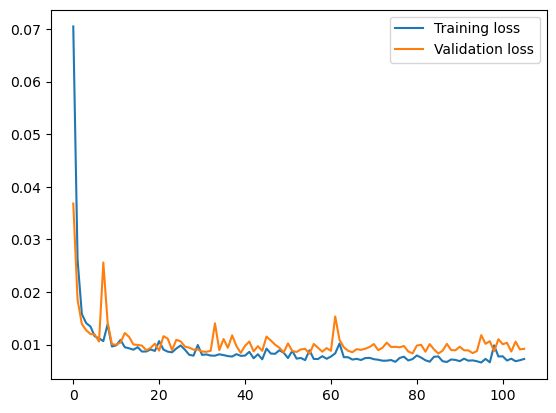

Epoch 1/10000
24/24 [==============================] - 3s 96ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 2/10000
24/24 [==============================] - 2s 90ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 3/10000
24/24 [==============================] - 2s 89ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 4/10000
24/24 [==============================] - 2s 91ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 5/10000
24/24 [==============================] - 2s 90ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 6/10000
24/24 [==============================] - 2s 89ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 7/10000
24/24 [==============================] - 2s 87ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 8/10000
24/24 [==============================] - 2s 91ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 9/10000
24/24 [==============================] - 2s 88ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 10/10000
24/24 [==============================] - 2s 88ms/step - loss: 0.007

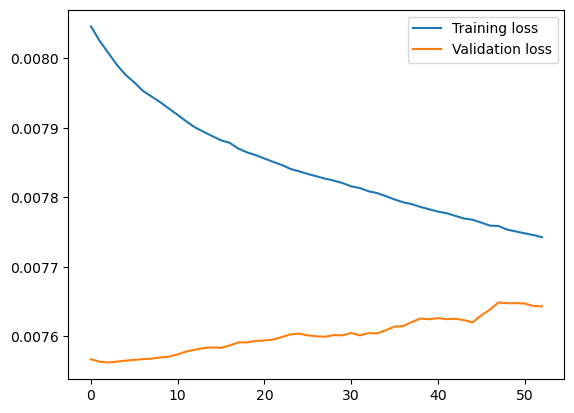

Epoch 1/10000
24/24 [==============================] - 3s 97ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 2/10000
24/24 [==============================] - 2s 90ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 3/10000
24/24 [==============================] - 2s 87ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 4/10000
24/24 [==============================] - 2s 85ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 5/10000
24/24 [==============================] - 2s 85ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 6/10000
24/24 [==============================] - 2s 87ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 7/10000
24/24 [==============================] - 2s 89ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 8/10000
24/24 [==============================] - 2s 83ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 9/10000
24/24 [==============================] - 2s 82ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 10/10000
24/24 [==============================] - 2s 87ms/step - loss: 0.007

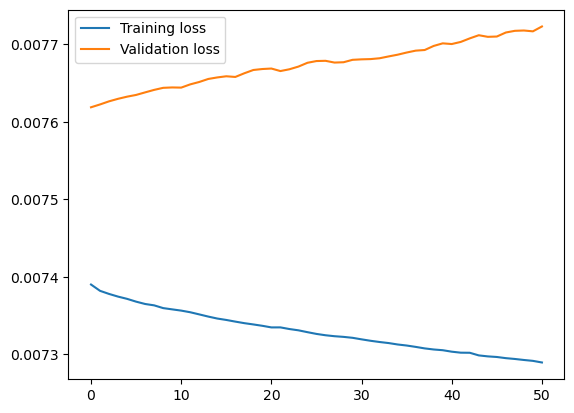

In [25]:
tl = TL(path, df, input_tag=input_tag)

models = [tl.model_wi,tl.model_fe,tl.model_fe_wi,
          tl.modelo_cru]
meses = 1

tl_option = ['wi_1', 'fe_1', 'fewi_1',
            'cru_1']

for m, o in zip(models, tl_option):
    tl.training(m, months = meses)
    tl.save(m,o,cce)

#Fine tuning
ft = [tl.model_fe, tl.model_fe_wi]
tl_option = ['fe_ft_1', 'fewi_ft_1']

    
for m, o in zip(ft, tl_option):
    tl.fine_tuning(m, months = meses)
    tl.save(m,o,cce)

Epoch 1/10000
130/130 [==============================] - 6s 38ms/step - loss: 0.0198 - val_loss: 0.0132
Epoch 2/10000
130/130 [==============================] - 5s 37ms/step - loss: 0.0172 - val_loss: 0.0159
Epoch 3/10000
130/130 [==============================] - 5s 35ms/step - loss: 0.0165 - val_loss: 0.0134
Epoch 4/10000
130/130 [==============================] - 5s 36ms/step - loss: 0.0160 - val_loss: 0.0134
Epoch 5/10000
130/130 [==============================] - 4s 34ms/step - loss: 0.0166 - val_loss: 0.0137
Epoch 6/10000
130/130 [==============================] - 4s 32ms/step - loss: 0.0163 - val_loss: 0.0137
Epoch 7/10000
130/130 [==============================] - 5s 35ms/step - loss: 0.0158 - val_loss: 0.0128
Epoch 8/10000
130/130 [==============================] - 4s 33ms/step - loss: 0.0152 - val_loss: 0.0142
Epoch 9/10000
130/130 [==============================] - 4s 33ms/step - loss: 0.0150 - val_loss: 0.0143
Epoch 10/10000
130/130 [==============================] - 4s 32m

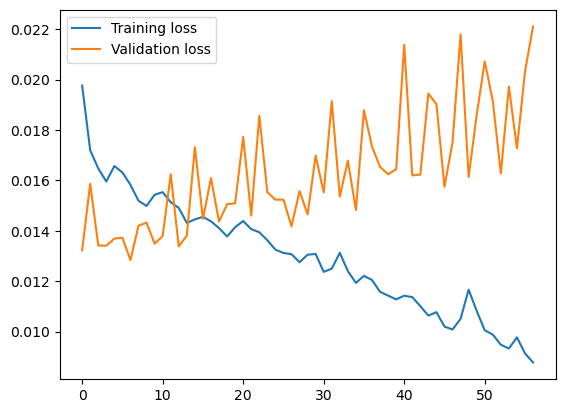

"\n#Fine tuning\nft = [tl.model_fe, tl.model_fe_wi]\ntl_option = ['fe_ft_6', 'fewi_ft_6']\n\n    \nfor m, o in zip(ft, tl_option):\n    tl.fine_tuning(m, months = meses)\n    tl.save(m,o,cce)\n\n#models = [tl.model,tl.model_wi,tl.model_fe,tl.model_fe_wi,tl.model_fe_output, tl.model_fe_wi_output, tl.modelo_cru]"

In [34]:
tl = TL(path, df, input_tag=input_tag)

models = [tl.model_wi,tl.model_fe,tl.model_fe_wi,
          tl.modelo_cru]
meses = 6

tl_option = ['wi_6']

for m, o in zip(models, tl_option):
    tl.training(m, months = meses)
    tl.save(m,o,cce)

#Fine tuning
ft = [tl.model_fe, tl.model_fe_wi]
tl_option = ['fe_ft_6', 'fewi_ft_6']

    
for m, o in zip(ft, tl_option):
    tl.fine_tuning(m, months = meses)
    tl.save(m,o,cce)

#models = [tl.model,tl.model_wi,tl.model_fe,tl.model_fe_wi,tl.model_fe_output, tl.model_fe_wi_output, tl.modelo_cru]"""

Epoch 1/10000
197/197 [==============================] - 9s 43ms/step - loss: 0.0098 - val_loss: 0.0090
Epoch 2/10000
197/197 [==============================] - 9s 44ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 3/10000
197/197 [==============================] - 8s 41ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 4/10000
197/197 [==============================] - 8s 42ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 5/10000
197/197 [==============================] - 8s 42ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 6/10000
197/197 [==============================] - 8s 41ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 7/10000
197/197 [==============================] - 9s 44ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 8/10000
197/197 [==============================] - 9s 44ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 9/10000
197/197 [==============================] - 9s 44ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 10/10000
197/197 [==============================] - 9s 45m

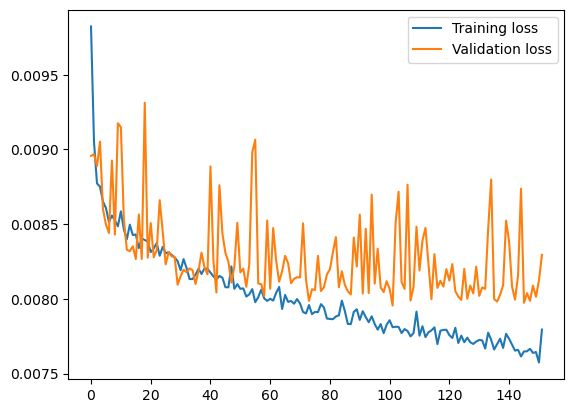

Epoch 1/10000
197/197 [==============================] - 18s 85ms/step - loss: 0.0077 - val_loss: 0.0080
Epoch 2/10000
197/197 [==============================] - 17s 85ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 3/10000
197/197 [==============================] - 17s 87ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 4/10000
197/197 [==============================] - 16s 83ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 5/10000
197/197 [==============================] - 17s 84ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 6/10000
197/197 [==============================] - 16s 84ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 7/10000
197/197 [==============================] - 17s 88ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 8/10000
197/197 [==============================] - 17s 88ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 9/10000
197/197 [==============================] - 18s 90ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 10/10000
197/197 [==============================]

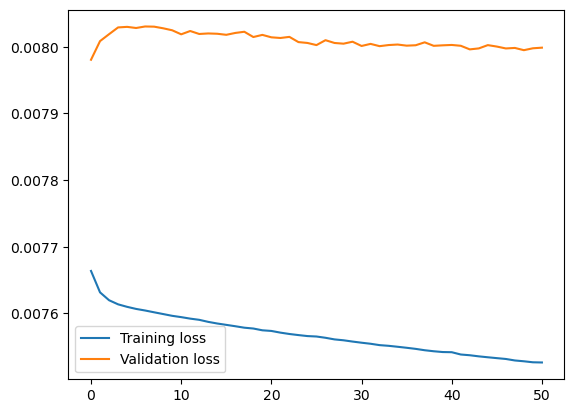

In [22]:
tl = TL(path, df, input_tag=input_tag)

models = [tl.model_wi,tl.model_fe,tl.model_fe_wi,
          tl.modelo_cru]
meses = 9

tl_option = ['wi_9', 'fe_9', 'fewi_12',
            'cru_12']


for m, o in zip(models, tl_option):
    tl.training(m, months = meses)
    tl.save(m,o,cce)

#Fine tuning
ft = [tl.model_fe, tl.model_fe_wi]
tl_option = ['fe_ft_9', 'fewi_ft_9']

    
for m, o in zip(ft, tl_option):
    tl.fine_tuning(m, months = meses)
    tl.save(m,o,cce)


Epoch 1/10000
66/66 [==============================] - 4s 45ms/step - loss: 0.0109 - val_loss: 0.0128
Epoch 2/10000
66/66 [==============================] - 3s 43ms/step - loss: 0.0102 - val_loss: 0.0126
Epoch 3/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.0099 - val_loss: 0.0125
Epoch 4/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.0097 - val_loss: 0.0124
Epoch 5/10000
66/66 [==============================] - 3s 43ms/step - loss: 0.0097 - val_loss: 0.0124
Epoch 6/10000
66/66 [==============================] - 3s 41ms/step - loss: 0.0096 - val_loss: 0.0123
Epoch 7/10000
66/66 [==============================] - 3s 42ms/step - loss: 0.0096 - val_loss: 0.0122
Epoch 8/10000
66/66 [==============================] - 3s 41ms/step - loss: 0.0096 - val_loss: 0.0122
Epoch 9/10000
66/66 [==============================] - 3s 41ms/step - loss: 0.0095 - val_loss: 0.0121
Epoch 10/10000
66/66 [==============================] - 3s 44ms/step - loss: 0.009

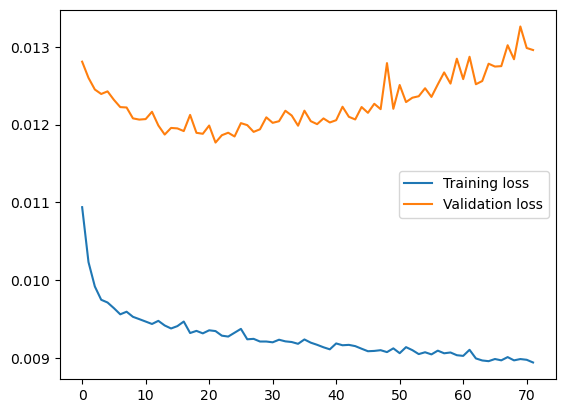

Epoch 1/10000
66/66 [==============================] - 7s 88ms/step - loss: 0.0092 - val_loss: 0.0117
Epoch 2/10000
66/66 [==============================] - 6s 85ms/step - loss: 0.0092 - val_loss: 0.0117
Epoch 3/10000
66/66 [==============================] - 6s 86ms/step - loss: 0.0092 - val_loss: 0.0117
Epoch 4/10000
66/66 [==============================] - 5s 82ms/step - loss: 0.0092 - val_loss: 0.0117
Epoch 5/10000
66/66 [==============================] - 5s 83ms/step - loss: 0.0092 - val_loss: 0.0117
Epoch 6/10000
66/66 [==============================] - 5s 80ms/step - loss: 0.0092 - val_loss: 0.0117
Epoch 7/10000
66/66 [==============================] - 6s 84ms/step - loss: 0.0092 - val_loss: 0.0117
Epoch 8/10000
66/66 [==============================] - 6s 88ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 9/10000
66/66 [==============================] - 6s 87ms/step - loss: 0.0092 - val_loss: 0.0116
Epoch 10/10000
66/66 [==============================] - 6s 90ms/step - loss: 0.009

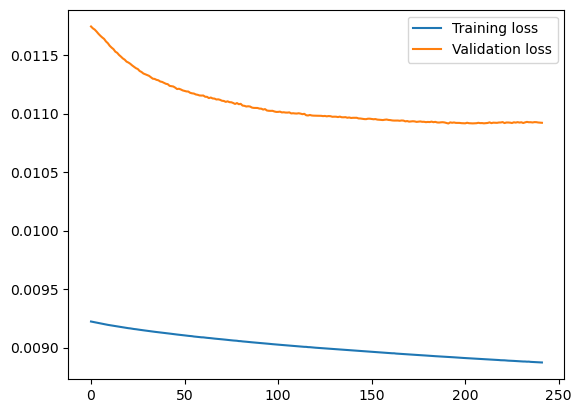

In [13]:
tl = TL(path, df, input_tag=input_tag)

models = [tl.model_wi,tl.model_fe,tl.model_fe_wi,
          tl.modelo_cru]

meses = 12

tl_option = ['wi_12', 'fe_12', 'fewi_12',
            'cru_12']

for m, o in zip(models, tl_option):
    tl.training(m, months = meses)
    tl.save(m,o,cce)

#Fine tuning
ft = [tl.model_fe, tl.model_fe_wi]
tl_option = ['fe_ft_12', 'fewi_ft_12']

for m, o in zip(ft, tl_option):
    tl.fine_tuning(m, months = meses)
    tl.save(m,o,cce)

# Lineplot tl

/tmp/ipykernel_702/1003709980.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_p1 = df_p1.applymap(lambda x: min(x, df['Potencia_Planta (MW)'].values[0]))
/tmp/ipykernel_702/1003709980.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_p2 = df_p2.applymap(lambda x: min(x, df['Potencia_Planta (MW)'].values[0]))
/tmp/ipykernel_702/1003709980.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_p3 = df_p3.applymap(lambda x: min(x, df['Potencia_Planta (MW)'].values[0]))
/home/fernando/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fernando/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

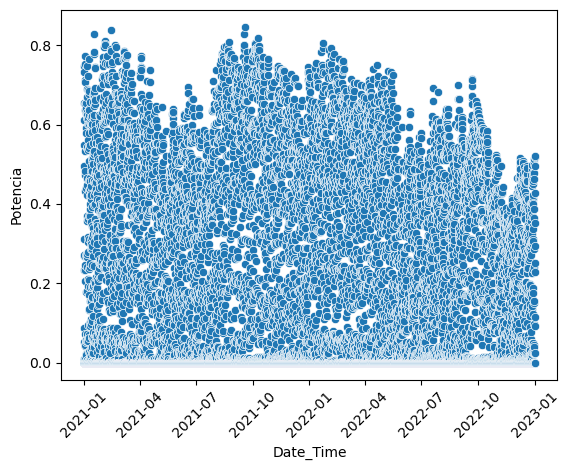

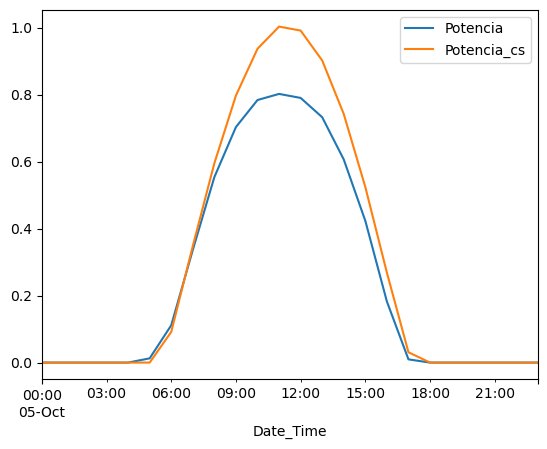

CCE13.csv 2020-12-31 21:00:00 2022-12-31 20:00:00


In [125]:
pontos = ['NEKT_tl.csv','CCE03.csv', 'CCE13.csv', 'CCE14.csv', 'CCE18.csv', 'CCE21.csv', 'CCE22.csv', 'CCE25.csv', 'CCE27.csv', 'CCE29.csv', 'CCE30.csv', 'CCE31.csv']
latitude =  [-23.045, -15.54 , -9.07  , -9.071 , -15.129, -27.578, -27.058, -9.541,  -27.688, -27.356, -22.816, -6.004]
longitude = [-46.674, -43.628, -38.147, -38.146, -44.139, -48.508, -52.785, -48.538, -53.307, -53.189, -47.059, -40.275]
#uf_list =     ['SP', 'PE', 'PE', 'MG', 'SC', 'SC', 'TO', 'RS', 'RS', 'SP', 'CE']
#regiao_list = ['SE', 'NE', 'NE', 'SE', 'S', 'S', 'N', 'S', 'S', 'SE', 'NE']
# 0, 2, 4, 5
i = 2


df = create_df(pontos[i], latitude[i], longitude[i])
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day


ax = sns.scatterplot(data = df['Potencia'])
plt.xticks(rotation=45)
plt.show()

b = df[['Potencia']].resample('D').mean()
c = b.loc[b['Potencia']==max(b['Potencia'])].index
c = str(c[0])[:10]

ini = f'{c} 00:00:00'
f = f'{c} 23:00:00'
df[['Potencia', 'Potencia_cs']].loc[ini:f].plot()
plt.show()

print(pontos[i],df.index[0], df.index[-1])

#path = "EDLSTM_72t_300u_3f_P.h5"
#path = "LSTM_24t_300u_3f_PAZ.h5"
path = "EDLSTM_24t_300u_3f_PAZ.h5"

input_tag = ['Potencia','cos_zenith','sin_azimuth']
#input_tag = ['Potencia','sin_azimuth','cos_zenith']
#input_tag = ['Potencia']

cce = pontos[i][:-4]

tl = TL(path, df, input_tag=input_tag)

In [126]:
import tensorflow as tf
import os

# Função para obter o índice de entrada
def obter_entrada(tamanho):
    if tamanho == 1:
        return 0
    elif tamanho == 3:
        return 1
    elif tamanho == 6:
        return 2
    else:
        return 3


# Configurações iniciais
resultados = Avaliacao(tl.df_teste)
path_model = fr"/mnt/c/Users/ferna/OneDrive/Documentos/mestrado/Modelos/Base de dados novas/Transfer Learning/EDLSTM_PAZ/{cce}"
modelos = os.listdir(path_model)
input_options = [
    ['Pot_BT'],
    ['Pot_BT', 'cos_zenith', 'sin_azimuth'],
    ['Irradiação Global horária(Inclinada 27°) kWh/m2', 'cos_zenith', 'sin_azimuth', 'Velocidade média do vento m/s', 'Umidade Relativa %', 'Temperatura ambiente °C'],
    ['Irradiação Global horária(Inclinada 27°) kWh/m2', 'cos_zenith', 'sin_azimuth', 'Degradacao', 'Velocidade média do vento m/s', 'Umidade Relativa %', 'Temperatura ambiente °C']
]
erro = list()
certo = list()

for m in modelos:
    try:
        model_path = os.path.join(path_model, m)
        try:
            model = tf.keras.models.load_model(model_path)
        except:
            model = tl.EDLSTM(path)
            model.load_weights(model_path)
        # Extraindo partes relevantes do nome do modelo
        m = m[:-3]
        parts = m.split('_')
        p = ''
        for i in parts[5:]:
            p += i
            
        janela = int(parts[1][:2])
        input_idx = obter_entrada(len(parts[-1][:-3]))
        
        # Obtendo janelas e entradas apropriadas
        #xs, ys, ysi = janela_flutuante(tl.df_teste, janela, 3, input_options[input_idx])
        
        # Adicionando o modelo aos resultados
        resultados.adicionar_modelo(model, tl.xs, tl.ys, tl.ysi, p)
        certo.append(m)
    except Exception as e:
        erro.append((m, str(e)))

#del(xs,ys,ysi)

# Opcional: Exibir erros detalhados para debug
for model_name, error in erro:
    print(f"Erro ao processar o modelo {model_name}: {error}")



resultados.erros()
n = resultados.df_info
n = n.drop_duplicates(subset = ['Modelo'])
n[['model','h']] = n['Modelo'].str.split("_",expand = True)
n.drop(columns = ['Horizonte', 'Modelo'], inplace = True)
n.drop(n.loc[(n['model']=='P1') | (n['model']=='P2') | (n['model']=='P3')].index, inplace = True)
n['meses'] = n.model.str[-1]
n['meses'].loc[n['meses']=='2'] = '12'
n['model'].loc[n['meses']!='12'] = n['model'].loc[n['meses']!='12'].str[:-1]
n['model'].loc[n['meses']=='12'] = n['model'].loc[n['meses']=='12'].str[:-2]

lin = n.copy()

68/68 [==============================] - 1s 10ms/step


/tmp/ipykernel_702/1245802137.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n[['model','h']] = n['Modelo'].str.split("_",expand = True)
/tmp/ipykernel_702/1245802137.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n[['model','h']] = n['Modelo'].str.split("_",expand = True)
/tmp/ipykernel_702/1245802137.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

/tmp/ipykernel_702/4106966960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['meses'] = x['meses'].astype('int')
/home/fernando/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fernando/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fernando/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: F

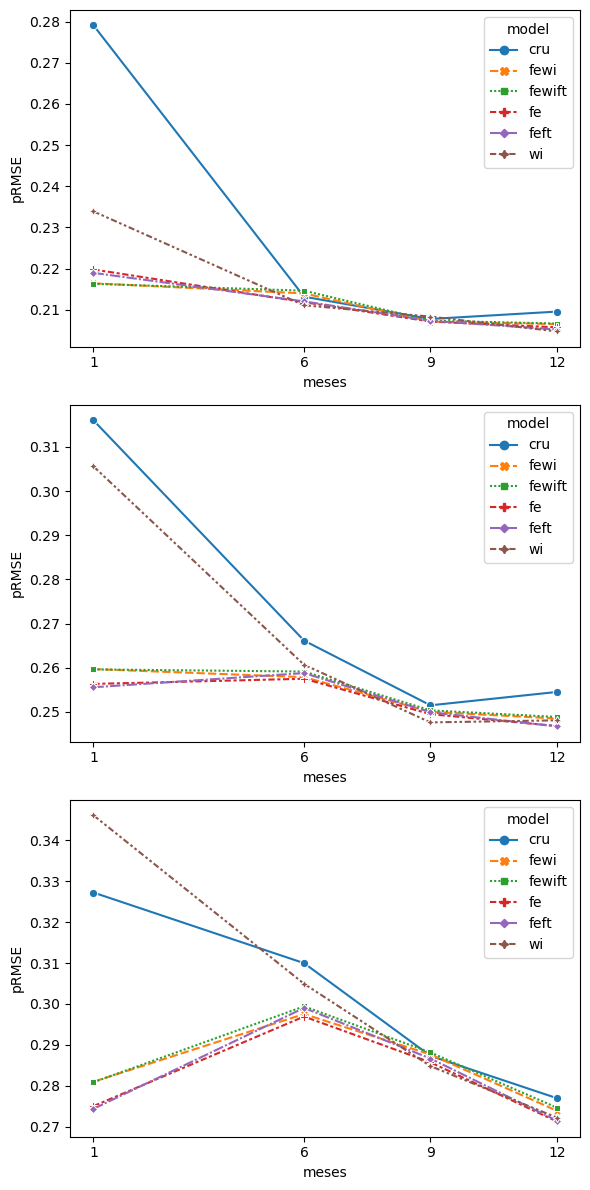

In [51]:
fig, ax = plt.subplots(3, figsize = (6,12))  # Create a figure with 3 subplots
for i, h in enumerate(n['h'].unique()):
    x = n.loc[n['h'] == h]
    x['meses'] = x['meses'].astype('int')
    sns.lineplot(data=x,
                 x='meses',
                 y='pRMSE',
                 hue='model',
                 style='model',  # Adiciona estilo com base no modelo
                 markers=True,   # Ativa os marcadores
                 ax=ax[i])
    ax[i].set_xticks([1,6,9,12])
plt.tight_layout()

### Repeticao

In [127]:
import tensorflow as tf
import os

# Função para obter o índice de entrada
def obter_entrada(tamanho):
    if tamanho == 1:
        return 0
    elif tamanho == 3:
        return 1
    elif tamanho == 6:
        return 2
    else:
        return 3

# Configurações iniciais
resultados = Avaliacao(tl.df_teste)
path_model = fr"/mnt/c/Users/ferna/OneDrive/Documentos/mestrado/Modelos/Base de dados novas/Transfer Learning/EDLSTM_PAZ/repeticao/{cce}"
modelos = os.listdir(path_model)
input_options = [
    ['Pot_BT'],
    ['Pot_BT', 'cos_zenith', 'sin_azimuth'],
    ['Irradiação Global horária(Inclinada 27°) kWh/m2', 'cos_zenith', 'sin_azimuth', 'Velocidade média do vento m/s', 'Umidade Relativa %', 'Temperatura ambiente °C'],
    ['Irradiação Global horária(Inclinada 27°) kWh/m2', 'cos_zenith', 'sin_azimuth', 'Degradacao', 'Velocidade média do vento m/s', 'Umidade Relativa %', 'Temperatura ambiente °C']
]
erro = list()
certo = list()

for m in modelos:
    try:
        model_path = os.path.join(path_model, m)
        model = tf.keras.models.load_model(model_path)
        
        # Extraindo partes relevantes do nome do modelo
        m = m[:-3]
        parts = m.split('_')
        p = ''
        for i in parts[5:]:
            p += i
            
        janela = int(parts[1][:2])
        input_idx = obter_entrada(len(parts[-1][:-3]))
        
        # Obtendo janelas e entradas apropriadas
        #xs, ys, ysi = janela_flutuante(tl.df_teste, janela, 3, input_options[input_idx])
        
        # Adicionando o modelo aos resultados
        resultados.adicionar_modelo(model, tl.xs, tl.ys, tl.ysi, p)
        certo.append(m)
    except Exception as e:
        erro.append((m, str(e)))

#del(xs,ys,ysi)

# Opcional: Exibir erros detalhados para debug
for model_name, error in erro:
    print(f"Erro ao processar o modelo {model_name}: {error}")


resultados.erros()
n = resultados.df_info
n = n.drop_duplicates(subset = ['Modelo'])
n[['model','h']] = n['Modelo'].str.split("_",expand = True)
n.drop(columns = ['Horizonte', 'Modelo'], inplace = True)
n.drop(n.loc[(n['model']=='P1') | (n['model']=='P2') | (n['model']=='P3')].index, inplace = True)
n['rep'] = n.model.str[-1]
n['rep'].loc[n['model'].str[-2]=='1'] = n['model'].loc[n['model'].str[-2]=='1'].str[-2:]
n['model'].loc[n['model'].str[-2]!='1'] = n['model'].loc[n['model'].str[-2]!='1'].str[:-1]
n['model'].loc[n['model'].str[-2]=='1'] = n['model'].loc[n['model'].str[-2]=='1'].str[:-2]

box = n.copy()

68/68 [==============================] - 1s 10ms/step


/tmp/ipykernel_702/962777778.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n[['model','h']] = n['Modelo'].str.split("_",expand = True)
/tmp/ipykernel_702/962777778.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n[['model','h']] = n['Modelo'].str.split("_",expand = True)
/tmp/ipykernel_702/962777778.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [128]:
mapeamento = {
    "cru": "Sem TL",
    "fewi": "TL3",
    "fewift": "TL5",
    "fe": "TL2",
    "feft": "TL4",
    "wi": "TL1"
}

box['model'] = box['model'].replace(mapeamento)
lin['model'] = lin['model'].replace(mapeamento)

/home/fernando/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fernando/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fernando/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fernando/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

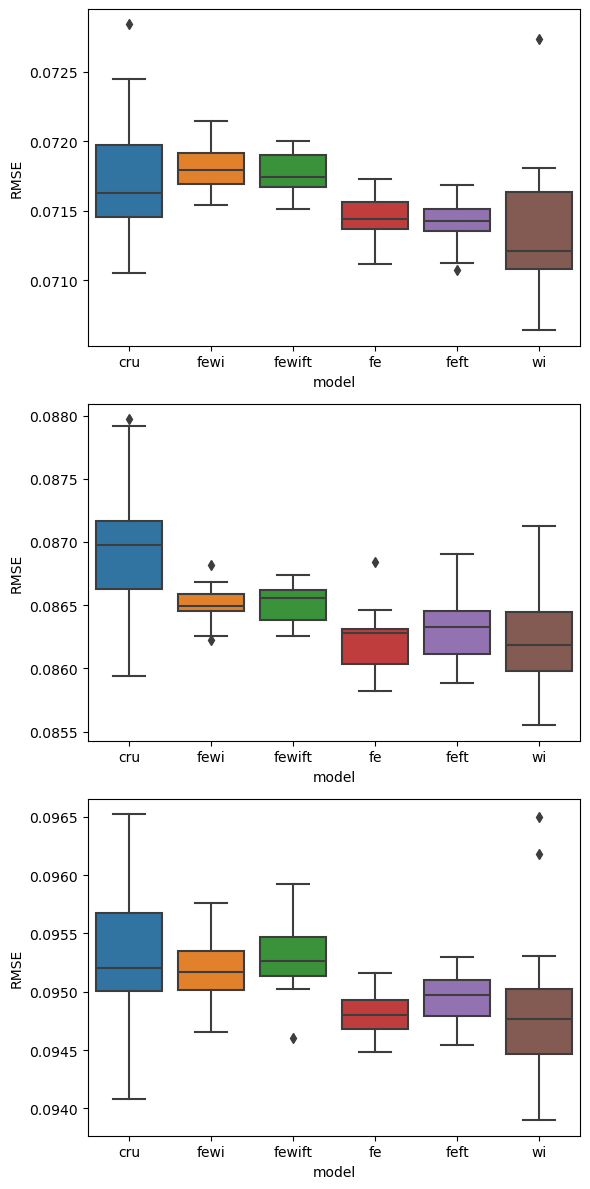

In [53]:
fig, ax = plt.subplots(3, figsize = (6,12))  # Create a figure with 3 subplots
for i, h in enumerate(box['h'].unique()):
    x = box.loc[box['h'] == h]
    #x['meses'] = x['meses'].astype('int')
    sns.boxplot(data=x,
                 x='model',
                 y='RMSE',
                 #hue='model',
                 ax=ax[i])  # Plot on the i-th subplot
    #ax[i].set_xticks([1,6,9,12])
plt.tight_layout()